## Álvaro e Rafael

In [ ]:
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import spacy
import unidecode
import gensim
import multiprocessing
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from nltk.stem.lancaster import LancasterStemmer
from gensim.models import Word2Vec,Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from collections import Counter
from sklearn import utils
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics.pairwise import cosine_similarity
from sklearnex import patch_sklearn
patch_sklearn()

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
plt.rcParams["figure.figsize"] = [21,9]
plt.rcParams['figure.dpi'] = 300

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('rslp')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

nlp = spacy.load('en_core_web_trf')

stopwords = nltk.corpus.stopwords.words('english')
cores = multiprocessing.cpu_count()

c:\Users\rafae\anaconda3\envs\PLN\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rafae\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rafae\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\rafae\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rafae\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading pa

### Pré-processamento para Word2Vec

In [ ]:
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=False, lst_stopwords=None, remove_accents = False):
    
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub('\w*\d\w*', ' ', text)
    text = ' '.join(text.split())
    text = ''.join(c for c in text if not c.isdigit())

    # doc = nlp(text)
    # lst_text = [token.text for token in doc]
    # lst_text = ' '.join(text)
    lst_text = text.split()
            
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
              
    if flg_stemm == True:
        ps = LancasterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]

    if flg_lemm == True:
        lst_text = nlp(text)
        lst_text = [word.lemma_ for word in lst_text if word.pos_ == 'VERB' or word.pos_ == 'NOUN']
    
    if remove_accents == True:
        lst_text = [unidecode.unidecode(word) for word in lst_text]
    
    text = " ".join(lst_text)
    return text

def tokenizer(column):
    new_column = []
    for doc in nlp.pipe(column, disable=['parser', 'tagger', 'ner'], n_process= 8):
        text = [token.text for token in doc]
        new_column.append(' '.join(text))
    return new_column

    
def clean_text(df):
    df['clean_text'] = tokenizer(df['article'])
    df['clean_text'] = df['clean_text'].apply(lambda x: utils_preprocess_text(x,False,False,stopwords,False))
    display(df.head(5))
    return df

df = pd.read_csv("../files_and_targets.csv")
df = clean_text(df)
df.to_csv('clean_dataset_no_stemming.csv',index = False)

In [ ]:
df = pd.read_csv('clean_dataset_no_stemming.csv')
df.head(5)

,filename,title,article,target,clean_text
0,289.txt,UK economy facing 'major risks'\n,"The UK manufacturing sector will continue to face ""serious challenges"" over the next two years, the British Chamber of Commerce (BCC) has said.\n\nThe group's quarterly survey of companies found exports had picked up in the last three months of 2004 to their best levels in eight years. The rise came despite exchange rates being cited as a major concern. However, the BCC found the whole UK economy still faced ""major risks"" and warned that growth is set to slow. It recently forecast economic growth will slow from more than 3% in 2004 to a little below 2.5% in both 2005 and 2006.\n\nManufacturers' domestic sales growth fell back slightly in the quarter, the survey of 5,196 firms found. Employment in manufacturing also fell and job expectations were at their lowest level for a year.\n\n""Despite some positive news for the export sector, there are worrying signs for manufacturing,"" the BCC said. ""These results reinforce our concern over the sector's persistent inability to sustain recovery."" The outlook for the service sector was ""uncertain"" despite an increase in exports and orders over the quarter, the BCC noted.\n\nThe BCC found confidence increased in the quarter across both the manufacturing and service sectors although overall it failed to reach the levels at the start of 2004. The reduced threat of interest rate increases had contributed to improved confidence, it said. The Bank of England raised interest rates five times between November 2003 and August last year. But rates have been kept on hold since then amid signs of falling consumer confidence and a slowdown in output. ""The pressure on costs and margins, the relentless increase in regulations, and the threat of higher taxes remain serious problems,"" BCC director general David Frost said. ""While consumer spending is set to decelerate significantly over the next 12-18 months, it is unlikely that investment and exports will rise sufficiently strongly to pick up the slack.""\n",business,uk manufacturing sector continue face serious challenges next two years british chamber commerce bcc said group quarterly survey companies found exports picked last three months best levels eight years rise came despite exchange rates cited major concern however bcc found whole uk economy still faced major risks warned growth set slow recently forecast economic growth slow little manufacturers domestic sales growth fell back slightly quarter survey firms found employment manufacturing also fell job expectations lowest level year despite positive news export sector worrying signs manufacturing bcc said results reinforce concern sector persistent inability sustain recovery outlook service sector uncertain despite increase exports orders quarter bcc noted bcc found confidence increased quarter across manufacturing service sectors although overall failed reach levels start reduced threat interest rate increases contributed improved confidence said bank england raised interest rates five times november august last year rates kept hold since amid signs falling consumer confidence slowdown output pressure costs margins relentless increase regulations threat higher taxes remain serious problems bcc director general david frost said consumer spending set decelerate significantly next months unlikely investment exports rise sufficiently strongly pick slack
1,504.txt,Aids and climate top Davos agenda\n,"Climate change and the fight against Aids are leading the list of concerns for the first day of the World Economic Forum in the Swiss resort of Davos.\n\nSome 2,000 business and political leaders from around the globe will listen to UK Prime Minister Tony Blair's opening speech on Wednesday. Mr Blair will focus on Africa's development plans and global warming. Earlier in the day came an update on efforts to have 3 million people on anti-Aids drugs by the end of 2005. The World Health Organisation (WHO) sa

Usando sua base de textos após os pré-processamentos realizados na lista 1, realize as seguintes tarefas:
## 1. O objetivo dessa questão é desenvolver um buscador de documentos.


### a) escolha e aplique um modelo do tipo word2vec a seus textos, compatível como idioma de seus textos (inglês ou português).

In [ ]:
def create_corpus(text):
    corpus = ' '.join([word for word in text])
    return sorted(set(corpus.split(' ')))

corpus = create_corpus(df['clean_text'].values)

model = gensim.models.KeyedVectors.load_word2vec_format(r'C:\Users\rafae\Documents\PLN\GoogleNews-vectors-negative300.bin', binary=True)


### b) escolha 5 palavras de consulta que não estejam em nenhum dos textos. Para cada palavra de consulta, encontre as 3 palavras de seu conjunto de textos mais parecidas com cada uma das palavras de consulta e exiba os documentos onde estas palavras aparecem.

In [ ]:
word_list = ['nonremittal','hurl','empirical','ribbon','radiation']
[print(word in corpus) for word in word_list]

False
False
False
False
False


[None, None, None, None, None]

In [ ]:
def find_sim_words(model,search_word):
  similar = []
  for word in corpus:
    try:
      similarity = model.similarity(word, search_word)
    except:
      similarity = -1
    similar.append(similarity)
  similar = np.argsort(similar)[-3:]
  similar = similar[::-1]
  return [corpus[i] for i in similar]

sim_word_list = []
for word in word_list:
    sim_word_list.append([word,find_sim_words(model,word)])

sim_word_df = pd.DataFrame(data=sim_word_list, columns=['Palavra','Palavras similares'])
display(sim_word_df)

,Palavra,Palavras similares
0,nonremittal,"[zvyagintsev, finegold, fines]"
1,hurl,"[hurling, flung, throw]"
2,empirical,"[theoretical, anecdotal, scientific]"
3,ribbon,"[wreath, garland, purple]"
4,radiation,"[radioactivity, radioactive, irradiated]"


In [ ]:
def find_documents(similar_words):
    complete_list = []
    for word in similar_words:
        aux_df = df[df['clean_text'].str.contains(word)]
        aux_df.loc[:,('Palavras similares')] = word
        complete_list.append(aux_df)
    similar_documents_df = pd.concat(complete_list)
    similar_documents_df = similar_documents_df[['article','Palavras similares']]
    display(similar_documents_df)

#### Palavra: nonremittal 
#### Palavras similares: [zvyagintsev, finegold, fines]

In [ ]:
find_documents(sim_word_df['Palavras similares'][0])

C:\Users\rafae\AppData\Local\Temp\ipykernel_1900\2036546118.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux_df.loc[:,('Palavras similares')] = word
C:\Users\rafae\AppData\Local\Temp\ipykernel_1900\2036546118.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux_df.loc[:,('Palavras similares')] = word
C:\Users\rafae\AppData\Local\Temp\ipykernel_1900\2036546118.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

article  \
853                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        Russian drama The Return (Vozvrashchenie) has been named winner of the BBC Four World Cinema Award.\n\nThe film tells the story of two adolescent boys who are subjected to a harsh regime when their strict father returns after a 10-year absence. Directed by Andrey Zvyagintsev, The Return previously won the 2003 Golden Lion award at the Venice Film Festival. The prize was presented at an awards ceremony held in London on Thursday and hosted by Jonathan Ross. The winner was chosen by a pa

#### Palavra: hurl
#### Palavras similares: [hurling, flung, throw]

In [ ]:
find_documents(sim_word_df['Palavras similares'][1])

C:\Users\rafae\AppData\Local\Temp\ipykernel_1900\2036546118.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux_df.loc[:,('Palavras similares')] = word
C:\Users\rafae\AppData\Local\Temp\ipykernel_1900\2036546118.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux_df.loc[:,('Palavras similares')] = word
C:\Users\rafae\AppData\Local\Temp\ipykernel_1900\2036546118.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

article  \
2048                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       Could Half-Life 2 possibly live up to the hype? After almost two years of tantalising previews and infuriating delays it's safe to say that this is the most highly-anticipated computer game of all time.\n\nFortunately, it doesn't merely live up to its promise, but exceeds it. No-one who plays the finished product will wonder why it took so long. The impression is of a game that has been endlessly refined to get as close to perfection as could realistically be hoped. All the money - or indeed time - is on the screen. The player sees things through the eyes of Gordon Freeman, the bespectacled scientist who starred in the original 1998 Half-Life. Having survived that skirmish in an desolate monster-infested research facility, he's back in another foreboding troublespot - the enigmatic City 17. It has the look of a beautiful Eastern European city, but as soon as your train pulls in to the station, it's clear that all is not well here. Sinister police patrol the unkempt streets, and the oppressive atmosphere clobbers you like a sledgehammer. A casual smattering of the nightmarish creatures from the first game makes this an even less pleasant place to be.\n\nYou are herded around like a prisoner and have to mingle with a few freedom-fighting civilians to gather information and progress in your task. It is not immediately explained what your objectives are, nor precisely why everything is so ravaged. Finding out step-by-step is all part of the experience, although you never fully get to understand what it was all about. That does not really matter. HL2 does not waste energy blinding you with plot. Underplaying the narrative in this way is gloriously effective, and immerses the player in the most vivid, convincing and impressive virtual world they are likely to have seen. There are no cut-scenes to interrupt the flow. Exposition is accomplished by other characters stopping to talk directly to you.\n\nWhereas the highly impressive Doom III felt like a top-notch theme park thrill-ride, wandering through Half-Life's world truly does feel like being part of a movie.\n\nConsidering its sophistication, the game runs surprisingly well on computers that only just match the modest minimum specifications. But if ever there was an incentive to upgrade your PC's components, this is it. On our test machine - an Alienware system with an Athlon 3500+ processor and ATI's Radeon X800 video card - everything ran at full quality without trouble, and the visual experience was simply jaw-dropping. It is not simply that the surfaces, textures and light effects push the technical envelope without mercy, but that such care and artistic flair has gone into designing them. The haunting, grim landscapes become strangely beautiful. Luckily you get time to pause mid-task and marvel at the awesome graphical flourishes of your surroundings. So impressive are the physics that you'll find yourself hurling bits of rubbish around and prodding floating corpses just to marvel at the lifelike way they move. There are puzzles to be solved along the way, pitched at about the right difficulty, but most progress is achieved by force. Freeman is quickly reunited with the original game's famous crowbar, and an array of more sophisticated weapons soon follow.\n\nVirtually anything not nailed to the floor can be interacted with, and in realistic fashion. You will be wowed by the attention-to-d

#### Palavra: empirical
#### Palavras similares: [theoretical, anecdotal, scientific]

In [ ]:
find_documents(sim_word_df['Palavras similares'][2])

C:\Users\rafae\AppData\Local\Temp\ipykernel_1900\2036546118.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux_df.loc[:,('Palavras similares')] = word
C:\Users\rafae\AppData\Local\Temp\ipykernel_1900\2036546118.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux_df.loc[:,('Palavras similares')] = word
C:\Users\rafae\AppData\Local\Temp\ipykernel_1900\2036546118.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

article  \
1848                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         A 22-year-old gamer has spent $26,500 (£13,700) on an island that exists only in a computer role-playing game (RPG).\n\nThe Australian gamer, known only by his gaming moniker Deathifier, bought the island in an online auction. The land exists within the game Project Entropia, an RPG which allows thousands of players to interact with each other. Entropia allows gamers to buy and sell virtual items using real cash, while fans of other titles often use auction site eBay to sell their virtual wares. Earlier this year economists calculated that these massively multi-player online role-playing games (MMORPGs) have a gross economic impact equivalent to the GDP of the African nation of Namibia.\n\n"This is a historic moment in gaming history, and this sale only goes to prove that massive multi-player online gaming has reached a new plateau," said Marco Behrmann, direc

#### Palavra: ribbon
#### Palavras similares: [wreath, garland, purple]

In [ ]:
find_documents(sim_word_df['Palavras similares'][3])

C:\Users\rafae\AppData\Local\Temp\ipykernel_1900\2036546118.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux_df.loc[:,('Palavras similares')] = word
C:\Users\rafae\AppData\Local\Temp\ipykernel_1900\2036546118.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux_df.loc[:,('Palavras similares')] = word
C:\Users\rafae\AppData\Local\Temp\ipykernel_1900\2036546118.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

article  \
1027                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   Prime Minister Tony Blair has arrived back from his diplomatic mission to the Middle East to try to resurrect the peace process.\n\nMr Blair held talks with his Israeli counterpart, Ariel Sharon, and the Palestinian leader, Mahmoud Abbas. He confirmed that a renewed drive to reform the Palestinian Authority and address security issues would come at a London conference in March. Mr Blair also made a surprise trip to Iraq this week. The Israelis described the meeting as important but said they would not need to attend. Mr Blair briefly visited the tomb of Yasser Arafat in Ramallah - the first world leader to do so. He nodded briefly towards the tomb, rather than lay a wreath, in what Palestinian officials said was a compromise gesture agreed at the last minute.\n\nThe BBC's Paul Reynolds says the London conference will be a limited measure to shore up the leadership of Mahmoud Abbas, also known as Abu Mazen, who is expected to win the Palestinian presidential election on 9 January. At a news conference following talks with Mr Blair, Mr Abbas said the British prime minister was "in a unique position to help us progress in our peaceful pursuit". He added: "Your endeavour to hold a conference in London is another example of your deep commitment to this purpose." In an interview with the BBC's political editor Andrew Marr, Mr Blair said getting progress between Israelis and Palestinians wo

#### Palavra: radiation
#### Palavras similares: [radioactivity, radioactive, irradiated]

In [ ]:
find_documents(sim_word_df['Palavras similares'][4])

C:\Users\rafae\AppData\Local\Temp\ipykernel_1900\2036546118.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux_df.loc[:,('Palavras similares')] = word
C:\Users\rafae\AppData\Local\Temp\ipykernel_1900\2036546118.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux_df.loc[:,('Palavras similares')] = word
C:\Users\rafae\AppData\Local\Temp\ipykernel_1900\2036546118.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

article  \
1192                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  Plans to allow foreign nuclear waste to be permanently stored in the UK have been branded "deeply irresponsible" by the Liberal Democrats.\n\nThe government has confirmed intermediate level waste (ILW) that was to have been shipped back to its home countries will now be stored in the UK. The cash raised will go towards the UK's nuclear clean-up programme. But Lib Dem Norman Baker accused ministers of turning Britain into a "nuclear dumpsite".\n\nUnder current contracts, British Nuclear Fuels should return all but low level waste, but none has ever been sent back. In future, only highly-radioactive waste will be sent back to its country of origin, normally Germany or Japan, under armed guard. Intermediate waste from countries such as Japan, Germany, Spain, Italy, Switzerland and Sweden will be stored permanently in the UK. At the moment, this waste is stored at Sellafield, in Cumbria, in the form of glass bricks, untreated liquid waste or solid material in drums. In a statement, the Department of Trade and Industry said the new policy meant there would be a "sixfold reduction in the number of waste shipments to overseas countries". And it said highly-radioactive waste would be returned to its home country sooner, ensuring there would be no overall increase in radioactivity.\n\nTrade Secretary Patricia Hewitt said the new arrangements, revealed in a Commons written statement, would raise up to £680m for Britain's nuclear clean-up programme, under the new Nuclear Decommissioning Agency. But the move has been criticised by environmental groups and the Liberal Democrats. Mr Baker, the Lib Dem environment spokesman, said: "I have been warning for months that this would happen and raised it with government several times. But now our worst fears have been confirmed. "Once again Britain's environmental and health needs are being ignored in policies driven by the Treasury and DTI. "This is a terrible attempt to offload some of the £48bn cost of cleaning up nuclear sites. "The Energy Act was

### c) Seja d um documento da base e w uma palavra de consulta. Implemente o seguinte algoritmo para buscar documentos:
#### 1. Encontre d10(w): a lista com as 10 palavras mais parecidas com w em um certo documento d.
#### 2. Para cada documento d, calcule a distância média DM10(w) entre w e as palavras de d10(w).
#### 3. Recupere os 3 documentos da base cuja DM10(w) é menor.

In [ ]:
def create_document_corpus(text):
    corpus = [word for word in text.split(' ')]
    return list(set(corpus))

def get_document_similar_list(document,selected_word):
    document_corpus = create_document_corpus(document)
    similar = []
    vectors = []
    for word in document_corpus:
        try:
            similarity = model.similarity(word, selected_word)
            word_vector = model.get_vector(word)
        except:
            similarity = -1
            word_vector = np.zeros((300,), dtype=np.float32)
        vectors.append(word_vector)
        similar.append(similarity)
    similar = np.argsort(similar)[-10:]
    similar = similar[::-1]

    return [document_corpus[i] for i in similar]

def get_average_distance(word_list,selected_word):
    mean_vector = np.mean(model[word_list],axis = 0, dtype = np.float64)
    return cosine_similarity([mean_vector],[model.get_vector(selected_word)]).flatten()[0]

search_word = 'uk'
df['similar_words'] = df.apply(lambda row: get_document_similar_list(str(row['clean_text']),search_word), axis = 1)
df['average_distance'] = df.apply(lambda row: get_average_distance(row['similar_words'],search_word), axis = 1)
top3_df = df.nlargest(3,'average_distance')
top3_df = top3_df[['clean_text','similar_words','average_distance']]
display(top3_df)
  


        
    
    

clean_text  \
1238                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

### d) aplique o algoritmo para buscar documentos em 5 palavras distintas, e exiba os 3 documentos mais próximos de cada um.

#### Palavra a ser buscada: threshold

In [ ]:
search_word = 'threshold'
df['similar_words'] = df.apply(lambda row: get_document_similar_list(str(row['clean_text']),search_word), axis = 1)
df['average_distance'] = df.apply(lambda row: get_average_distance(row['similar_words'],search_word), axis = 1)
top3_df = df.nlargest(3,'average_distance')
top3_df = top3_df[['clean_text','similar_words','average_distance']]
display(top3_df)

clean_text  \
1125  minimum wage rise october benefiting people government announced adults must paid least hour year olds paid recommendations came low pay commission said number jobs continued grow since minimum wage introduced businesses wanted frozen warning rises could damage competitiveness unions want rate increase adult rate hour provisionally scheduled october according commission many businesses found last two significant increases minimum wage challenging therefore recommended slight increase average earnings concentrated second year allow business time absorb impact said chairman adair turner government says minimum wage women many working cleaning catering shops hairdressing unveiling latest increase mr blair said wanted minimum wage become symbol decency fairness long poverty pay capped aspiration prosperity far many hard working families said often people told make choice indignity unemployment humiliation poverty pay chancellor gordon brown transport secretary alistair darling promoted news edinburgh wales secretary peter hain welsh first minister rhodri morgan cardiff northern ireland minister john spellar belfast government accepted commission recommendation year olds paid adult rate says look rate later mr brown said want nothing damage employment opportunities young people particularly young people entering labour market first time government said look tougher action small number employers consistently refuse pay minimum wage national minimum wage currently set per hour aged aged per hour minimum wage introduced last october year olds apprentices exempt trade unions congress welcomed increase called minimum wage next year confederation british industry cbi called pause year assess impact inflation rise minimum wage october david frost director british chambers commerce said level increase year increased rates far outstripping rates inflation employers saying us level starting bite competitiveness companies right across country liberal democrats economics spokesman vincent cable said supported move raise minimum wage good workers lifts benefits therefore good exchequer said conservative leader michael howard said accepted principle minimum wage would seek disturb increase speaking bbc radio woman hour mr howard hinted tories might go general election promise cancel income tax lowest paid workers people low salaries low incomes indeed really nt paying income tax said would better decrease taxes earnings year say tax losses tax recouped tax band people making minimum wage going effectively almost twice us minimum wage yet economy per person us perhaps really starting questioning products cost us combined tax decreases would make pounds low paid people make go much still good enough got part time job levels attempt get little money saved uni years ago getting paid hour working hard older staff maybe time year olds got fair wage must remember minimum wage part picture must rise level makes employing people unattractive encourages businesses send work therefore jobs abroad still government local councils employ staff via contractors pay minimum wage close easy way government preaches would insist floor pay levels government workers take tens thousand civil servants social security system together increase certainly welcome news however whining pressures increase minimum wage would simply ask would happy work less hour thought nt expect others either ca nt believe many comments minimum wage also personally take great offence insinuation people earning minimum wage lazy school everyone went university would serve supermarkets clean time hardworking people rewarded deserve earned fair pay bit respect would nt go miss either br gt good news minimum wage put sense equality back worker relationship employer wages supposed fair reflection employee efforts long wages point exploitation could employer get away simplistic terms put pressure keep low paid wages low minimum wage downward pressure least partly removed also in

#### Palavra a ser buscada: activation

In [ ]:
search_word = 'activation'
df['similar_words'] = df.apply(lambda row: get_document_similar_list(str(row['clean_text']),search_word), axis = 1)
df['average_distance'] = df.apply(lambda row: get_average_distance(row['similar_words'],search_word), axis = 1)
top3_df = df.nlargest(3,'average_distance')
top3_df = top3_df[['clean_text','similar_words','average_distance']]
display(top3_df)

,clean_text,similar_words,average_distance
1864,net browser opera due official release end next month accessible browser market according authors latest version net browser controlled voice command read pages aloud voice features based ibm technology currently available windows version opera also magnify text times users create style sheets developers say enable view pages colours fonts prefer browser yet work well screen reader software often used blind people accessibility features likely appeal residual vision mission always provide best internet experience everyone said opera spokeswoman berit hanson would obviously want exclude disabled computer users another feature likely appeal people low vision ability make pages fit screen width eliminates need horizontal scrolling company points also appeal anyone using opera handheld device company says features like voice activation solely aimed visually impaired people idea take first step making human computer interaction natural said ms hanson people always situation access keyboard makes web hands free experience unlike commercially available voice recognition software opera trained recognise individual voice around voice commands available users wear headset incorporates microphone voice recognition function currently available english opera free download paid version comes without ad banner top right hand corner extra support opera began life research project spin norwegian telecoms company telenor browser used estimated million people variety operating systems number different platforms,"[activation, function, interaction, device, users, download, ms, recognition, commands, residual]",0.637553
1878,net browser opera due official release end next month accessible browser market according authors latest version net browser controlled voice command read pages aloud voice features based ibm technology currently available windows version opera also magnify text times users create style sheets developers say enable view pages colours fonts prefer browser yet work well screen reader software often used blind people accessibility features likely appeal residual vision mission always provide best internet experience everyone said opera spokeswoman berit hanson would obviously want exclude disabled computer users another feature likely appeal people low vision ability make pages fit screen width eliminates need horizontal scrolling company points also appeal anyone using opera handheld device company says features like voice activation solely aimed visually impaired people idea take first step making human computer interaction natural said ms hanson people always situation access keyboard makes web hands free experience unlike commercially available voice recognition software opera trained recognise individual voice around voice commands available users wear headset incorporates microphone voice recognition function currently available english opera free download paid version comes without ad banner top right hand corner extra support opera began life research project spin norwegian telecoms company telenor browser used estimated million people variety operating systems number different platforms,"[activation, function, interaction, device, users, download, ms, recognition, commands, residual]",0.637553
2208,viewers could soon rewarded watching tv loyalty cards come screen near household hooked sky could soon using smartcards conjunction set top boxes broadcasters sky itv could offer viewers loyalty points return watching particular channel programme sky activate spare slot set top boxes january marketing magazine new media age reported sky set top boxes two slots one viewer decryption card dormant loyalty cards become common addition wallets high street brands rush keep customers series incentives offered store cards similar schemes look set enter highly competitive world multi channel tv viewers stay loyal particular tv channel could rewarded free tv content freebies retail partner

#### Palavra a ser buscada: twin

In [ ]:
search_word = 'twin'
df['similar_words'] = df.apply(lambda row: get_document_similar_list(str(row['clean_text']),search_word), axis = 1)
df['average_distance'] = df.apply(lambda row: get_average_distance(row['similar_words'],search_word), axis = 1)
top3_df = df.nlargest(3,'average_distance')
top3_df = top3_df[['clean_text','similar_words','average_distance']]
display(top3_df)

,clean_text,similar_words,average_distance
1885,people using wireless high speed net wi fi warned fake hotspots access points latest threat nicknamed evil twins pose real hotspots actually unauthorised base stations say cranfield university experts logged onto evil twin sensitive data intercepted wi fi becoming popular devices come wireless capability london leads global wi fi hotspots league number hotspots expected reach according analysts users need wary using wi fi enabled laptops portable devices order conduct financial transactions anything sensitive personal nature said professor brian collins head information systems cranfield university users also protect ensuring wi fi device security measures activated added bt openzone operates vast proportion public hotspots uk told bbc news website made every effort make wi fi secure naturally people may security concerns said chris clark chief executive bt wireless broadband wi fi networks less vulnerable means accessing internet like broadband dial said bt openzone well others sophisticated encryption start login process service hotspot means users personal information data logon usernames passwords protected secure said mr clark vast majority cases base stations straight box manufacturers automatically set least secure mode possible said dr nobles cybercriminals try glean personal information using scam jam connections legitimate base station sending stronger signal near wireless client anyone right gear find real hotspot substitute evil twin cybercriminals nt clever carry attack said dr phil nobles wireless net cybercrime expert cranfield wireless networks based radio signals easily detected unauthorised users tuning frequency although wi fi increasing popularity people want use high speed net move fears secure companies reluctant use large numbers fears security wireless network protected provide backdoor company computer system public wi fi hotspots offered companies like bt openzone cloud accessible users sign pay use many home company wi fi networks left unprotected sniffed hi jacked anyone correct equipment bt advises customers change default settings make sure security settings equipment configured correctly said mr clark also advocate use personal firewalls ensure authorised users access data intercepted dr nobles due speak wireless cybercrime science museum dana centre london thursday,"[twin, twins, evil, latest, carry, many, collins, like, large, also]",0.680860
781,late rb star aaliyah record company failed attempt sue video producer booked ill fated flight died new york appeals court told blackground records singer parents right launch claim wrongful death year old singer family came undisclosed settlement negligence claim aaliyah completed music video plane crashed bahamas eight others killed plane crashed left florida blackground records lawyer frank penski said yet examine decision know whether would pursue case investigation crash revealed twin engined cessna overloaded pounds kg post mortem carried remains pilot showed cocaine alcohol body aaliyah rising star music film killed honoured string posthumous awards single woman went number one uk,"[twin, eight, string, engined, old, new, fated, one, single, parents]",0.675459
774,screenwriter producer debra hill best known work horror classic halloween died los angeles aged hill suffering cancer co wrote film starred jamie lee curtis babysitter terrorised psychopath directed john carpenter made worldwide record independent film time hill also worked carpenter escape new york fog born new jersey hill began career production assistant worked way ranks becoming assistant director second unit director began collaborating carpenter regarded many pioneering woman film taking jobs commonly taken men back started women industry said assumed make hair person script person never assumed writer producer took look around realised nt many women carve niche carpenter said working hill one greatest experiences life ground trailbl

#### Palavra a ser buscada: liability

In [ ]:
search_word = 'liability'
df['similar_words'] = df.apply(lambda row: get_document_similar_list(str(row['clean_text']),search_word), axis = 1)
df['average_distance'] = df.apply(lambda row: get_average_distance(row['similar_words'],search_word), axis = 1)
top3_df = df.nlargest(3,'average_distance')
top3_df = top3_df[['clean_text','similar_words','average_distance']]
display(top3_df)

,clean_text,similar_words,average_distance
1049,tony blair says personal standing eyes voters issue general election prime minister said country waits go polls possibly matter weeks told observer government life constant barrage attack said would stay charge felt unable contribute mr blair also spoke meeting many people across country concerns compensation culture said britain danger needless panic public safety issues speaking amid flurry pre election campaigning prime minister said issue always whoever prime minister added afraid take criticism go another job asked would quit leader felt like liability labour said important always job unless feel something contribute whether still something offer said judgement people make mr blair assessment likely seen signal replacing would bring upsurge fortunes labour administration comments come co chairman conservative party liam fox saturday called disappointment historic proportions prime minister mr blair said learned series times tough encounters members public question answer sessions across country recent weeks pledged clamp britain growing compensation culture brought concerns doctors teachers professionals hampered work fear frivolous lawsuits quite shocked told people running nursery worried letting kids playground wet case one slipped fell ended legal case said got look way getting people protection mr blair said government also looking make sure legal aid abused actions doctors others part review carried lord chancellor department real debate risk posed public safety threats said danger depending whatever media campaign day ending spending literally hundreds sometimes millions pounds meeting quite small risk comments come government announced spend drugs treat possible outbreak bird flu sudan food scare meanwhile commons leader peter hain warned campaign trail seen dangerous complacency displayed labour voters convinced general election victory labour voters stayed home marginal seats could see tory leader michael howard coming back door number tradesman key number getting power added,"[liability, lawsuits, risk, compensation, legal, protection, case, charge, safety, danger]",0.701706
443,majority owner embattled russian oil firm yukos sued russian government kremlin last year seized sold yukos main production arm yugansk state run oil group rosneft offset massive back tax bill group menatep gibraltar based holding company controls yukos says illegal menatep already asked rosneft repay loan yugansk secured assets russian government argument selling yuganskneftegaz unit full name yukos owed back taxes years onwards accused firm using web offshore firms avoid tax liabilities courts sent bailiffs freeze yukos accounts seize yugansk critics say sell assault yukos finances part attempt bring energy industry back state control according menatep government actions contrary energy charter treaty designed regulate disagreements energy investments warned russian government continuing attacks yukos personnel shareholders warned buyer yuganskneftegaz would face lifetime litigation said tim osborne director group menatep time warning actions recover value losses begin earnest today menatep said value yukos shareholding gone virtually nothing since result russian government action shares fallen according paris lawyer emmanuel gaillard shearman sterling overall claim based figure addition share gains could accrued since arbitration lawsuit could take place stockholm hague mr gaillard said russia signed charter never ratified experts say could make difficult menatep press case mr gaillard told bbc news charter came effect signature ratification russia said past bound attract foreign investors said yukos still waiting see happen filing us court bankruptcy protection took action try prevent forced sale yugansk first little known shell company turn bought rosneft yukos claims downfall punishment political ambitions founder mikhail khodorkovsky mr khodorkovsky currently facing fraud tax evasio

#### Palavra a ser buscada: swimming


In [ ]:
search_word = 'swimming'
df['similar_words'] = df.apply(lambda row: get_document_similar_list(str(row['clean_text']),search_word), axis = 1)
df['average_distance'] = df.apply(lambda row: get_average_distance(row['similar_words'],search_word), axis = 1)
top3_df = df.nlargest(3,'average_distance')
top3_df = top3_df[['clean_text','similar_words','average_distance']]
display(top3_df)

,clean_text,similar_words,average_distance
1949,whipping mobile phone make call quaintly phones printed directly wrists parts body says ian pearson bt resident futurologist part known pervasive ambient world chips everywhere mr pearson crystal ball job formulate ideas based science technology guide industries future inanimate objects start interact us surrounded streets homes appliances bodies possibly heads things think forget local area networks body area networks ideas smart small even invisible technology get always floating around images devices clumsily bolted heads wrists pervaded thinking future technology new vision surfacing smart fabrics textiles exploited enhance functionality form aesthetics materials already starting change gadgets electronics used designed players mass gadget moment disappear instead become integrated one clothing says mr pearson gadgets fill handbag integrate fabric actually get rid stuff wo nt necessarily see electronics wearable technology could exploit body heat charge video tattoos intelligent electronic contact lenses might function tv screens move however future highly personal devices technology worn even fuses body raises ethical questions technology going increasingly part clothing jewellery skin needs serious thinking means us humans says baroness susan greenfield recent conference technology engineering academic fashion industry experts royal society london neuroscientist baroness greenfield cautioned ca nt sleepwalk future yet technology already upon us researchers developed computers sensors worn clothing jackets based idea electrically conductive fabric connect keyboard sewn sleeves already appeared shops smart fabrics come advances nano micro engineering ability manipulate exploit materials micro molecular scale nanoscale materials tuned display unusual properties exploited build faster lighter stronger efficient devices systems textile clothing industry one first exploit nanotechnology quite straightforward ways many developments appearing real products fields medicine defence healthcare sports communications professional swimming suits reduce drag incorporating tiny structures similar shark skin nanoscale titanium dioxide coatings give fabrics antibacterial anti odour properties special properties activated contact air uv light coatings already used stop socks smelling instance turn airline seats super stain resistant surfaces applied windows clean dressings wounds incorporate nanoparticles biocidal properties smart patches developed deliver drugs skin baroness greenfield concerned far personal contact technology might affect clothing skin personal body networks talking monitoring everywhere go think means concept privacy mr pearson picks theme pointing lot issues humans iron become cyborgian main concern privacy looking electronics really deep contact body lot information really nt want every passer know make sure build security wearing smart make electronics controlling appearance nt want people hacking writing messages forehead technology infiltrates biology brains function differently arrogantly assume human brain change warns baroness greenfield already successful experiments grow human nerve cells circuit boards paves way brain implants help paralysed people interface directly computers clearly organic carbon bodies silicon increasingly merging cyborg familiar part human part inorganic science fiction academic idea way,"[swimming, shark, sports, floating, academic, wearing, biology, surfacing, bodies, jackets]",0.693584
2122,grand theft auto series games set highest standards recent years newest addition able live increasingly grand tradition certificate gta san andreas playstation could got away merely revisiting best selling formula approach instead builds expands almost immeasurably upon last two games stomps carefree true crime shaped opposition even year see sequels halo half life hard envisage anything topping barnstorming instant classic basic gameplay remains fami

## 2. Resolva novamente a segunda questão da 2a lista e compare com os resultados obtidos anteriormente:

### a) Aplicando a representação vetorial Doc2Vec combinado com os classificadores usados anteriormente.

In [ ]:
print(Counter(df['target']))
new_target = {'sport': 1, 'business': 0, 'politics': 0, 'tech': 0, 'entertainment': 0}
df['binary_target'] = df['target'].map(new_target)
print(Counter(df['binary_target']))

Counter({'sport': 511, 'business': 510, 'politics': 417, 'tech': 401, 'entertainment': 386})
Counter({0: 1714, 1: 511})


In [ ]:
train, test = train_test_split(df, test_size=0.3, random_state=42)

def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens

train_tagged = train.apply(
    lambda row: TaggedDocument(words=tokenize_text(row['clean_text']), tags=[row['binary_target']]), axis=1)
test_tagged = test.apply(
    lambda row: TaggedDocument(words=tokenize_text(row['clean_text']), tags=[row['binary_target']]), axis=1)

In [ ]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

model_dmm = Doc2Vec(dm=1, dm_mean=1, vector_size=300, window=10, negative=5, min_count=1, workers=cores, alpha=0.065, min_alpha=0.065)
model_dmm.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 1557/1557 [00:00<00:00, 1563824.55it/s]


In [ ]:
for epoch in range(50):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 1557/1557 [00:00<?, ?it/s]


In [ ]:
for epoch in range(50):
    model_dmm.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dmm.alpha -= 0.002
    model_dmm.min_alpha = model_dmm.alpha

100%|██████████| 1557/1557 [00:00<?, ?it/s]


In [ ]:
from gensim.test.test_doc2vec import ConcatenatedDoc2Vec
new_model = ConcatenatedDoc2Vec([model_dbow, model_dmm])

In [ ]:
def get_vectors(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, epochs=20)) for doc in sents])
    return targets, regressors

y_train, X_train = get_vectors(new_model, train_tagged)
y_test, X_test = get_vectors(new_model, test_tagged)

#### Regressão Logística

Accuracy: 1.0
Detail:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       528
           1       1.00      0.99      0.99       140

    accuracy                           1.00       668
   macro avg       1.00      0.99      1.00       668
weighted avg       1.00      1.00      1.00       668



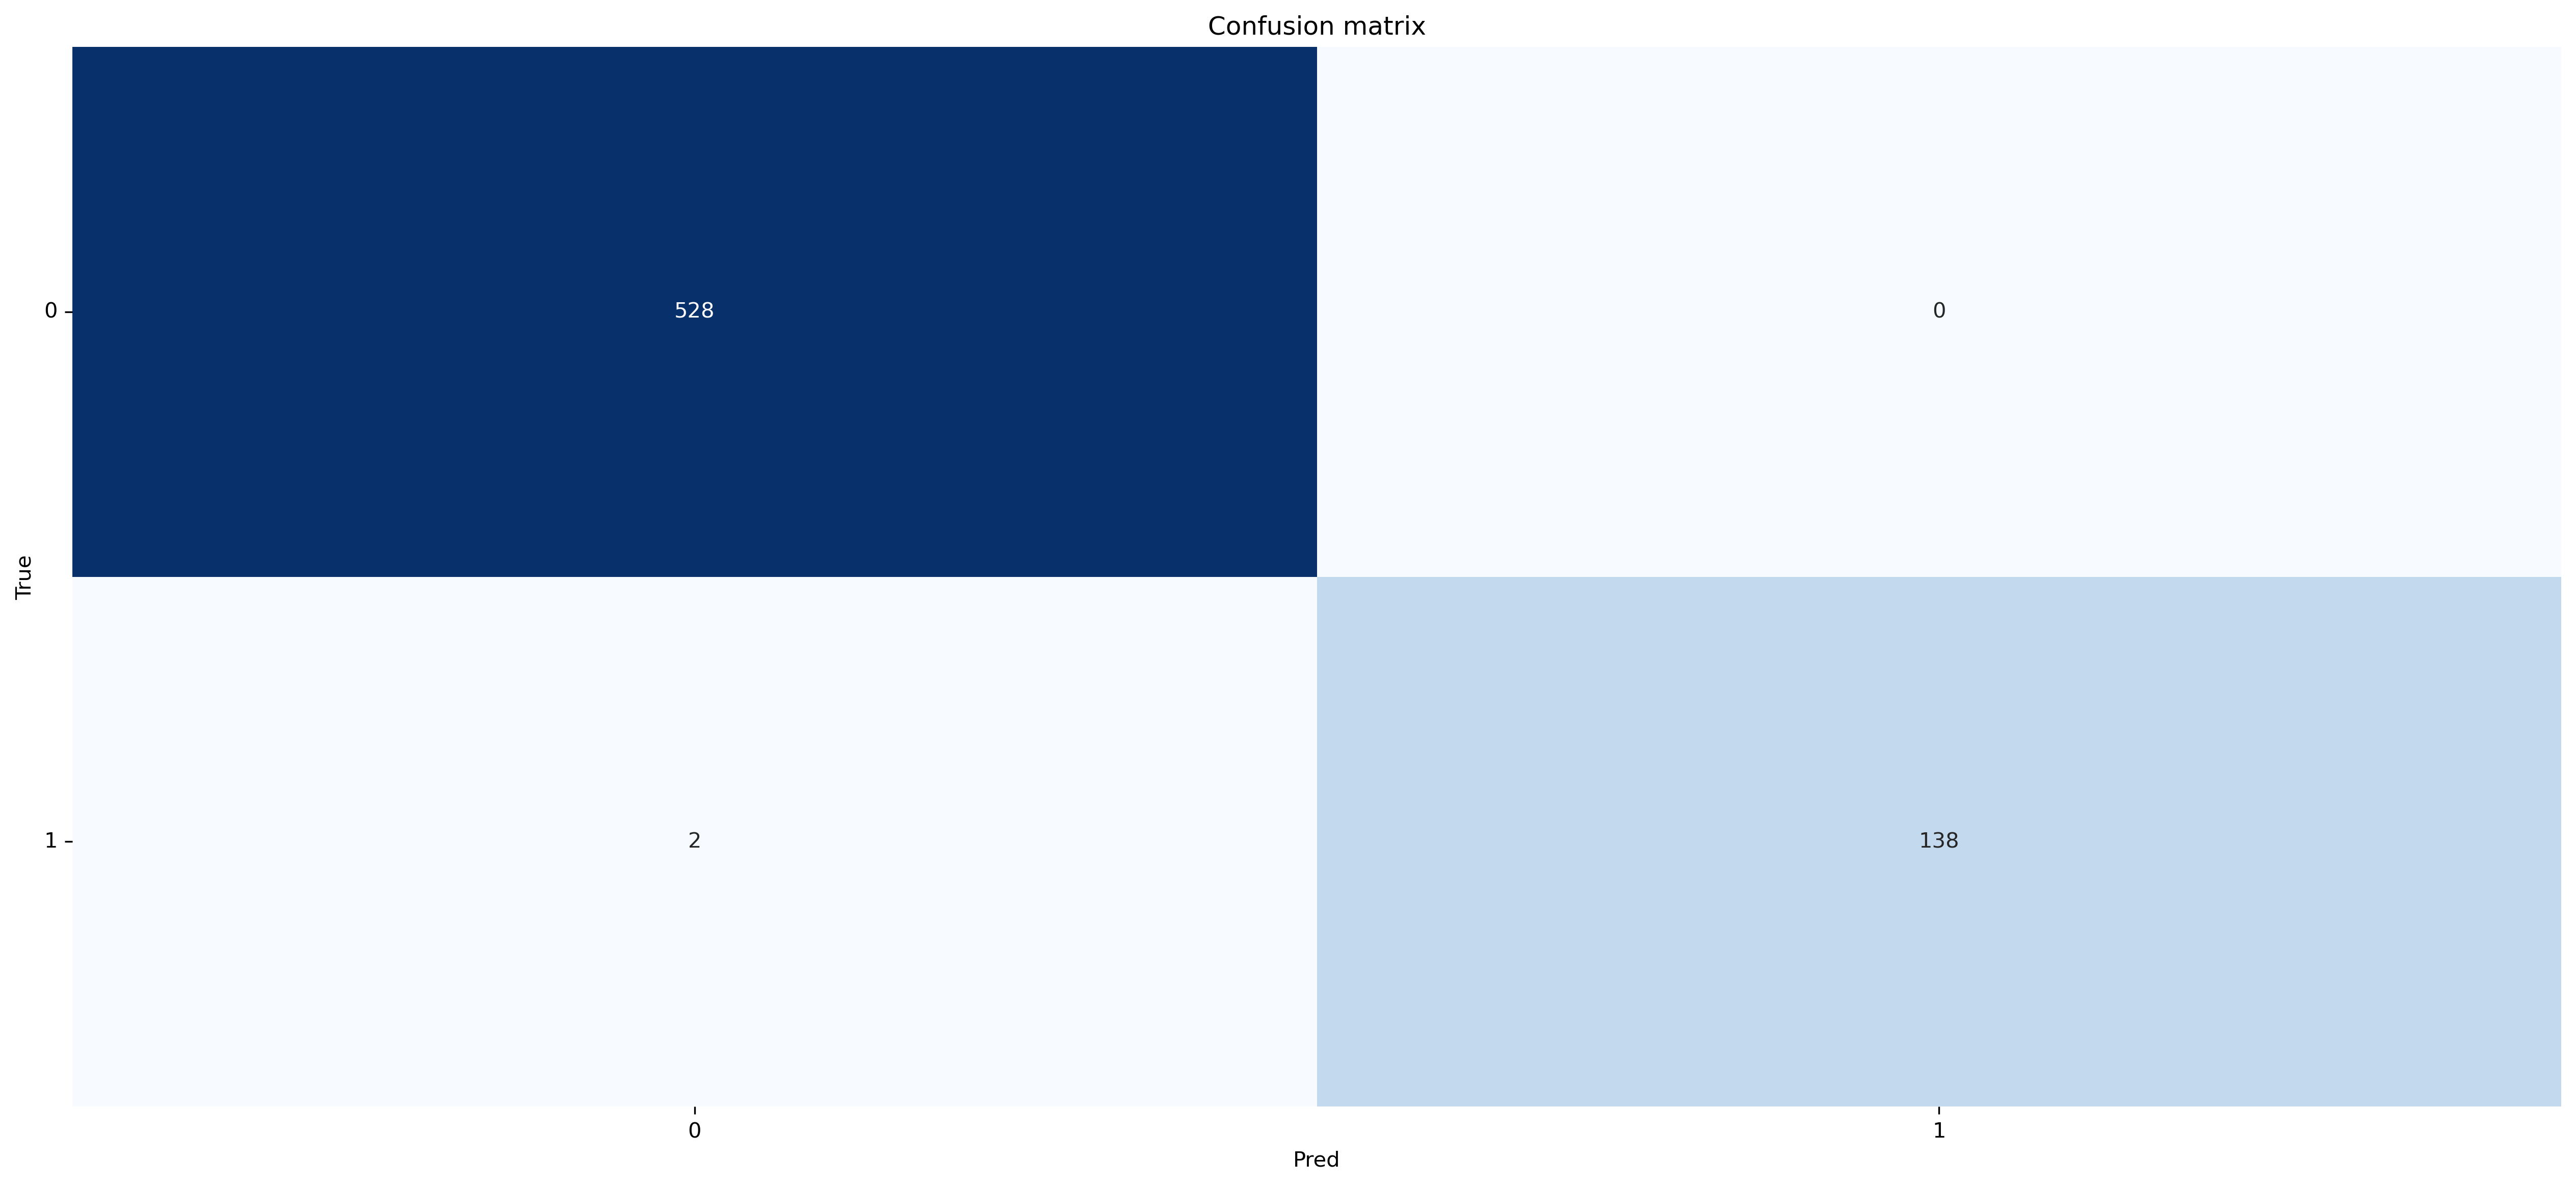

In [ ]:
def doc2vec_lr(X_train,X_test,y_train,y_test):
    logreg = LogisticRegression(n_jobs=-1, C=1e5, max_iter = 3000)
    logreg.fit(X_train, y_train)
    predicted = logreg.predict(X_test)

    classes = np.unique(y_test)
    y_test_array = pd.get_dummies(y_test, drop_first=False).values
        
    ## Accuracy, Precision, Recall
    accuracy = metrics.accuracy_score(y_test, predicted)
    # auc = metrics.roc_auc_score(y_test_array, predicted_prob)
    print("Accuracy:",  round(accuracy,2))
    # print("Auc:", round(auc,2))
    print("Detail:")
    print(metrics.classification_report(y_test, predicted))
        
    ## Plot confusion matrix
    cm = metrics.confusion_matrix(y_test, predicted)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
                cbar=False)
    ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
        yticklabels=classes, title="Confusion matrix")
    plt.yticks(rotation=0)

    return metrics.classification_report(y_test, predicted,output_dict=True)

metrics_lr = doc2vec_lr(X_train,X_test,y_train,y_test)

#### Gaussian Naive-Bayes

Accuracy: 0.76
Detail:
              precision    recall  f1-score   support

           0       0.95      0.73      0.83       528
           1       0.46      0.86      0.60       140

    accuracy                           0.76       668
   macro avg       0.71      0.80      0.71       668
weighted avg       0.85      0.76      0.78       668



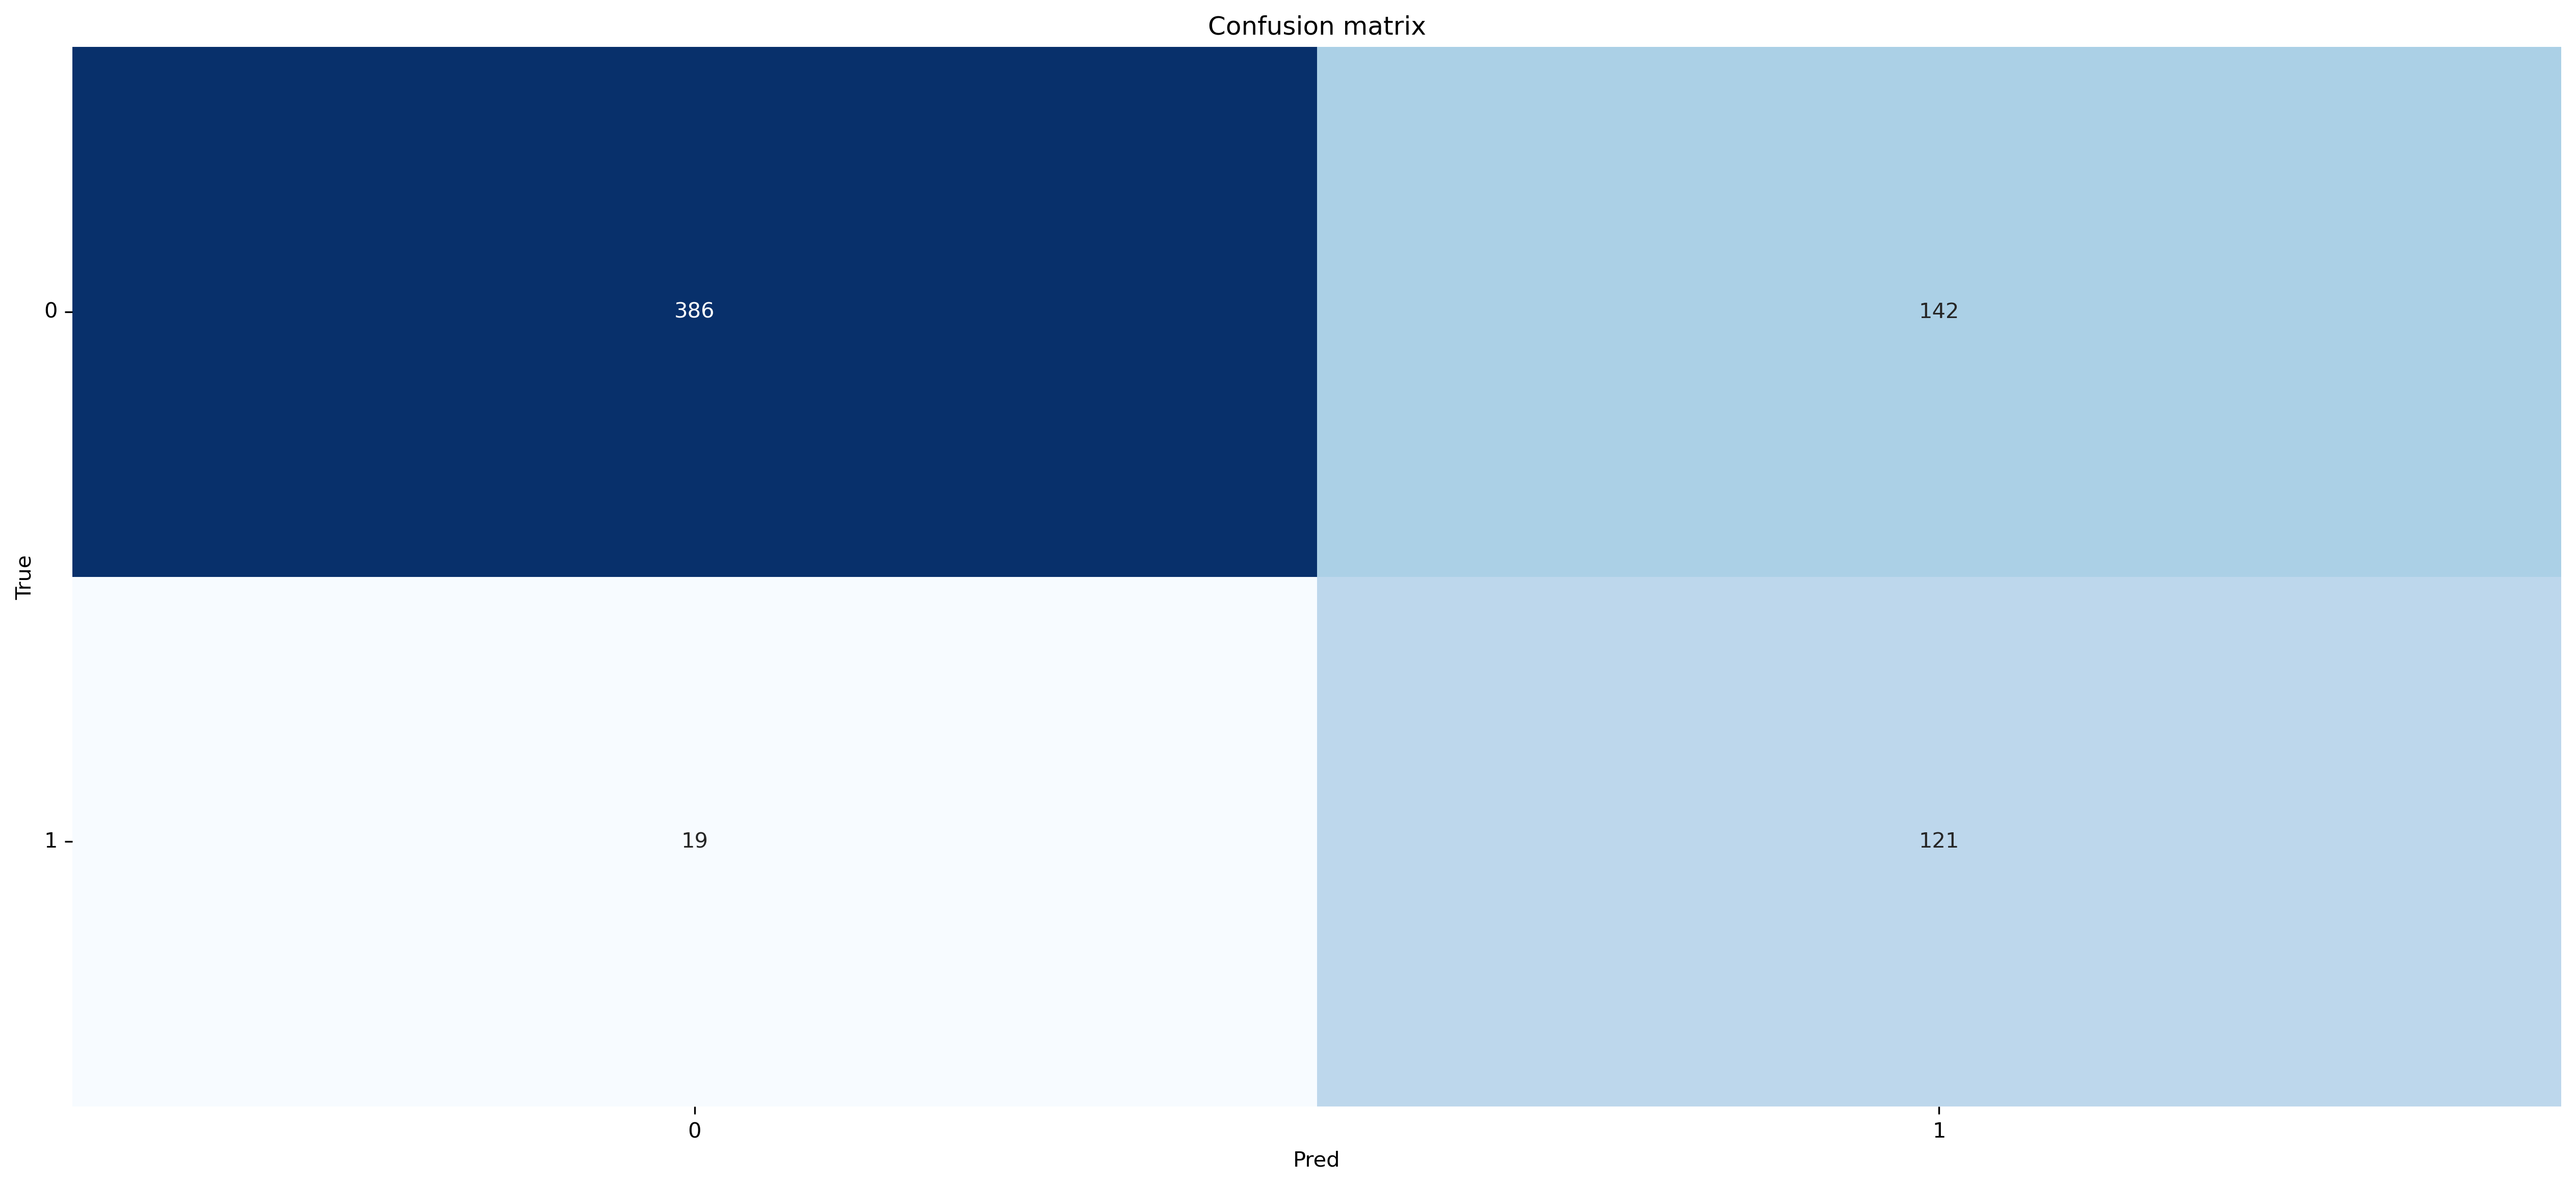

In [ ]:
def doc2vec_gaussianNB(X_train,X_test,y_train,y_test):
    gaussianNB = GaussianNB()
    gaussianNB.fit(X_train, y_train)
    predicted = gaussianNB.predict(X_test)

    classes = np.unique(y_test)
    y_test_array = pd.get_dummies(y_test, drop_first=False).values
        
    ## Accuracy, Precision, Recall
    accuracy = metrics.accuracy_score(y_test, predicted)
    # auc = metrics.roc_auc_score(y_test_array, predicted_prob)
    print("Accuracy:",  round(accuracy,2))
    # print("Auc:", round(auc,2))
    print("Detail:")
    print(metrics.classification_report(y_test, predicted))
        
    ## Plot confusion matrix
    cm = metrics.confusion_matrix(y_test, predicted)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
                cbar=False)
    ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
        yticklabels=classes, title="Confusion matrix")
    plt.yticks(rotation=0)

    return metrics.classification_report(y_test, predicted,output_dict=True)

metrics_gaussiannb = doc2vec_gaussianNB(X_train,X_test,y_train,y_test)

#### SGDClassifier

Accuracy: 0.99
Detail:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       528
           1       1.00      0.96      0.98       140

    accuracy                           0.99       668
   macro avg       1.00      0.98      0.99       668
weighted avg       0.99      0.99      0.99       668



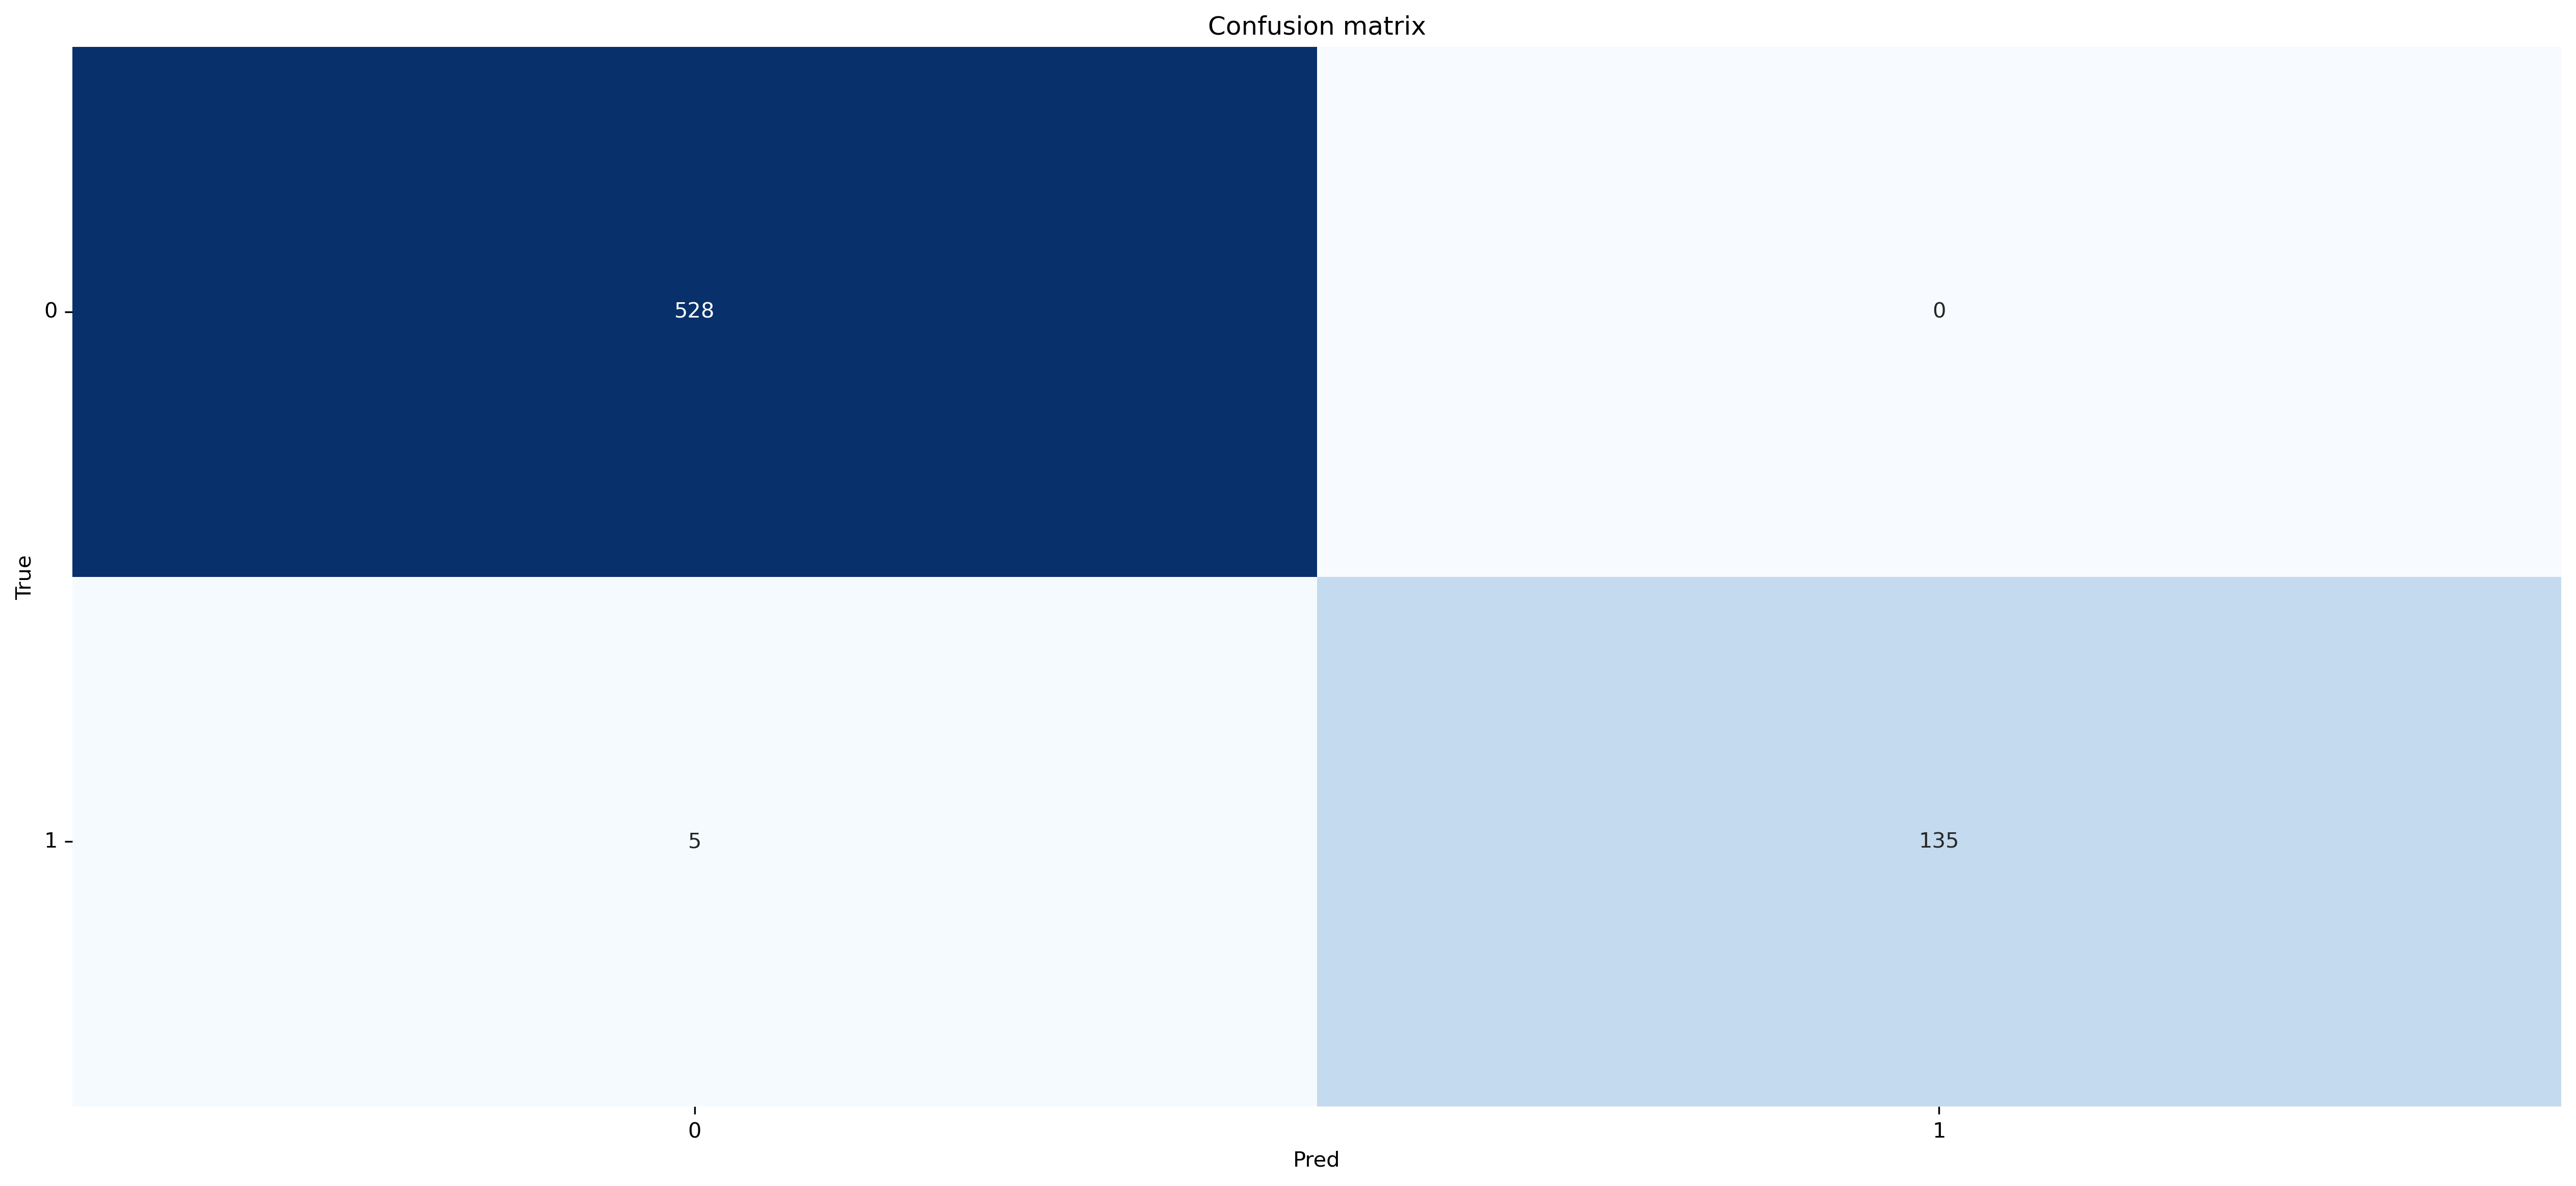

In [ ]:
def doc2vec_SGD(X_train,X_test,y_train,y_test):
    SGD = SGDClassifier(n_jobs= - 1)
    SGD.fit(X_train, y_train)
    predicted = SGD.predict(X_test)

    classes = np.unique(y_test)
    y_test_array = pd.get_dummies(y_test, drop_first=False).values
        
    ## Accuracy, Precision, Recall
    accuracy = metrics.accuracy_score(y_test, predicted)
    # auc = metrics.roc_auc_score(y_test_array, predicted_prob)
    print("Accuracy:",  round(accuracy,2))
    # print("Auc:", round(auc,2))
    print("Detail:")
    print(metrics.classification_report(y_test, predicted))
        
    ## Plot confusion matrix
    cm = metrics.confusion_matrix(y_test, predicted)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
                cbar=False)
    ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
        yticklabels=classes, title="Confusion matrix")
    plt.yticks(rotation=0)

    return metrics.classification_report(y_test, predicted,output_dict=True)

metrics_sgd = doc2vec_SGD(X_train,X_test,y_train,y_test)

### b) Usando pelo menos duas arquiteturas de redes neurais que utilizem camadas Embedding, convolucionais e LSTM.

In [ ]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers import GlobalMaxPool1D,Dropout, LSTM, Conv1D, GlobalAveragePooling1D, GlobalMaxPooling1D,Bidirectional
from keras_preprocessing.sequence import pad_sequences
from keras import backend as K
import tensorflow
tensorflow.config.experimental.list_physical_devices('GPU')
sess = tensorflow.compat.v1.Session(config=tensorflow.compat.v1.ConfigProto(log_device_placement=True))
# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6



In [ ]:
corpus = df['clean_text'].values
y = df['binary_target'].values
le = LabelEncoder()
le.fit(y)
y_enc = le.transform(y)
encode = OneHotEncoder()
y_one_hot_enc = encode.fit_transform(y_enc.reshape(-1,1)).toarray()
print(y_one_hot_enc)


[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [ ]:
from nltk.tokenize import word_tokenize

all_words = []
for sent in corpus:
    tokenize_word = word_tokenize(sent)
    for word in tokenize_word:
        all_words.append(word)

unique_words = set(all_words)
print(len(unique_words))

27614


In [ ]:
embedded_sentences = [one_hot(sent, len(unique_words) + 5) for sent in corpus]
print(embedded_sentences)

In [ ]:
word_count = lambda sentence: len(word_tokenize(sentence))
longest_sentence = max(corpus, key=word_count)
length_long_sentence = len(word_tokenize(longest_sentence))
print(length_long_sentence)

2209


In [ ]:
padded_sentences = pad_sequences(embedded_sentences, length_long_sentence, padding='post')
print(padded_sentences)

[[23903  1619  5449 ...     0     0     0]
 [ 7649 23337  1987 ...     0     0     0]
 [23495 13730 25721 ...     0     0     0]
 ...
 [11450 15994  9832 ...     0     0     0]
 [14154  7551 24916 ...     0     0     0]
 [ 8304  2674 22263 ...     0     0     0]]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(padded_sentences, y_one_hot_enc, test_size=0.3, random_state=42)

In [ ]:
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

#### Modelo 1 (Conv1D)

In [ ]:
model = Sequential()
model.add(Embedding(len(unique_words) + 5, 300, input_length=length_long_sentence))
model.add(Conv1D(48, 5, activation='relu', padding='valid'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid'))

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy',get_f1])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 2209, 300)         8285700   
                                                                 
 conv1d_1 (Conv1D)           (None, 2205, 48)          72048     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 48)               0         
 balMaxPooling1D)                                                
                                                                 
 dropout_3 (Dropout)         (None, 48)                0         
                                                                 
 flatten_1 (Flatten)         (None, 48)                0         
                                                                 
 dropout_4 (Dropout)         (None, 48)                0         
                                                      

In [ ]:
model.fit(X_train, y_train, epochs=100, verbose=1)

Epoch 1/100
49/49 [==============================] - 2s 20ms/step - loss: 0.5439 - accuracy: 0.7463 - get_f1: 0.7174
Epoch 2/100
49/49 [==============================] - 1s 19ms/step - loss: 0.3665 - accuracy: 0.8137 - get_f1: 0.8001
Epoch 3/100
49/49 [==============================] - 1s 20ms/step - loss: 0.2084 - accuracy: 0.9390 - get_f1: 0.8953
Epoch 4/100
49/49 [==============================] - 1s 19ms/step - loss: 0.1036 - accuracy: 0.9794 - get_f1: 0.9449
Epoch 5/100
49/49 [==============================] - 1s 19ms/step - loss: 0.0626 - accuracy: 0.9865 - get_f1: 0.9652
Epoch 6/100
49/49 [==============================] - 1s 19ms/step - loss: 0.0332 - accuracy: 0.9955 - get_f1: 0.9743
Epoch 7/100
49/49 [==============================] - 1s 19ms/step - loss: 0.0296 - accuracy: 0.9923 - get_f1: 0.9805
Epoch 8/100
49/49 [==============================] - 1s 20ms/step - loss: 0.0164 - accuracy: 0.9974 - get_f1: 0.9861
Epoch 9/100
49/49 [==============================] - 1s 19ms/ste

In [ ]:
loss, accuracy, f1_score = model.evaluate(X_test, y_test, verbose=1)
print('Accuracy: %f' % (accuracy*100))
print('F1 score: %f' % (f1_score*100))

21/21 [==============================] - 0s 13ms/step - loss: 0.1080 - accuracy: 0.9805 - get_f1: 0.9821
Accuracy: 98.053890
F1 score: 98.211926


#### Modelo 2 (LSTM)

In [ ]:
model2 = Sequential()
model2.add(Embedding(len(unique_words) + 5, 300, input_length=length_long_sentence))
model2.add(Dropout(0.6))
model2.add(Bidirectional(LSTM(300)))
model2.add(Dense(2,activation='sigmoid'))

In [ ]:
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy',get_f1])
print(model2.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 2209, 300)         8285700   
                                                                 
 dropout_5 (Dropout)         (None, 2209, 300)         0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 600)              1442400   
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 2)                 1202      
                                                                 
Total params: 9,729,302
Trainable params: 9,729,302
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
model2.fit(X_train, y_train, epochs=10, verbose=1)

Epoch 1/10
49/49 [==============================] - 20s 370ms/step - loss: 0.3341 - accuracy: 0.8536 - get_f1: 0.8494
Epoch 2/10
49/49 [==============================] - 18s 371ms/step - loss: 0.0115 - accuracy: 0.9987 - get_f1: 0.9987
Epoch 3/10
49/49 [==============================] - 18s 371ms/step - loss: 0.0217 - accuracy: 0.9955 - get_f1: 0.9955
Epoch 4/10
49/49 [==============================] - 18s 365ms/step - loss: 0.0068 - accuracy: 0.9994 - get_f1: 0.9994
Epoch 5/10
49/49 [==============================] - 18s 362ms/step - loss: 0.0214 - accuracy: 0.9981 - get_f1: 0.9981
Epoch 6/10
49/49 [==============================] - 18s 364ms/step - loss: 0.0076 - accuracy: 0.9994 - get_f1: 0.9994
Epoch 7/10
49/49 [==============================] - 18s 364ms/step - loss: 5.2806e-04 - accuracy: 1.0000 - get_f1: 1.0000
Epoch 8/10
49/49 [==============================] - 18s 363ms/step - loss: 2.2309e-04 - accuracy: 1.0000 - get_f1: 1.0000
Epoch 9/10
49/49 [==============================

In [ ]:
loss2, accuracy2, f1_score2 = model2.evaluate(X_test, y_test, verbose=1)
print('Accuracy: %f' % (accuracy2*100))
print('F1_score: %f' % (f1_score2*100))

21/21 [==============================] - 2s 110ms/step - loss: 0.0306 - accuracy: 0.9955 - get_f1: 0.9948
Accuracy: 99.550897
F1_score: 99.480313


### Comparações

In [ ]:
metric_list = [metrics_lr,metrics_gaussiannb,metrics_sgd]
metrics = ['Doc2Vec_LogisticRegression','Doc2Vec_NaiveBayes','Doc2Vec_SGD']
dl_metrics = ['Conv1D','LSTM']
dl_metrics_list = [f1_score,f1_score2]

print('''F1 Score de todas as 6 variações com tf-idf e count vectorizer:
CountVectorizer_LogisticRegression -> 0.9978756896853286
TF_IDF_LogisticRegression -> 0.9508113318695443
CountVectorizer_NaiveBayes -> 0.9652806652806654
TF_IDF_NaiveBayes -> 0.9647656095470429
CountVectorizer_SGD -> 0.991483068135455
TF_IDF_SGD -> 0.9936270690559857''')

print('\nF1 Score de todos os modelos com Doc2Vec:')

for i, metric in enumerate(metric_list):
    print(metrics[i] + ' -> ' + str(metric['macro avg']['f1-score']))

print('\nF1 Score de todos os modelos com Deep Learning:')

for i, metric in enumerate(dl_metrics_list):
    print(dl_metrics[i] + ' -> ' + str(dl_metrics_list[i]))

F1 Score de todas as 6 variações com tf-idf e count vectorizer:
CountVectorizer_LogisticRegression -> 0.9978756896853286
TF_IDF_LogisticRegression -> 0.9508113318695443
CountVectorizer_NaiveBayes -> 0.9652806652806654
TF_IDF_NaiveBayes -> 0.9647656095470429
CountVectorizer_SGD -> 0.991483068135455
TF_IDF_SGD -> 0.9936270690559857

F1 Score de todos os modelos com Doc2Vec:
Doc2Vec_LogisticRegression -> 0.9954576981137208
Doc2Vec_NaiveBayes -> 0.7139673243811819
Doc2Vec_SGD -> 0.9885528232370834

F1 Score de todos os modelos com Deep Learning:
Conv1D -> 0.9821192622184753
LSTM -> 0.9948031306266785


## 3. Usando sua base de textos:

### Pré-processamento

In [ ]:
# keras module for building LSTM 
from keras_preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from keras.models import Sequential
import keras.utils as ku 

# set seeds for reproducability
import tensorflow
#from tensorflow import set_random_seed
from numpy.random import seed
tensorflow.random.set_seed(2)
seed(1)

import pandas as pd
import numpy as np
import string, os 

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6



In [ ]:
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=False, lst_stopwords=None, remove_accents = False):
    
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub('\w*\d\w*', ' ', text)
    text = ' '.join(text.split())
    text = ''.join(c for c in text if not c.isdigit())

    # doc = nlp(text)
    # lst_text = [token.text for token in doc]
    # lst_text = ' '.join(text)
    lst_text = text.split()
            
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
              
    if flg_stemm == True:
        ps = LancasterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]

    if flg_lemm == True:
        lst_text = nlp(text)
        lst_text = [word.lemma_ for word in lst_text if word.pos_ == 'VERB' or word.pos_ == 'NOUN']
    
    if remove_accents == True:
        lst_text = [unidecode.unidecode(word) for word in lst_text]
    
    text = " ".join(lst_text)
    return text

def tokenizer(column):
    new_column = []
    for doc in nlp.pipe(column, disable=['parser', 'tagger', 'ner'], n_process= 8):
        text = [token.text for token in doc]
        new_column.append(' '.join(text))
    return new_column

    
def clean_text(df):
    df['clean_text'] = tokenizer(df['article'])
    df['clean_text'] = df['clean_text'].apply(lambda x: utils_preprocess_text(x))
    # display(df.head(5))
    return df

df = pd.read_csv("../files_and_targets.csv")
df = clean_text(df)
df.to_csv('clean_dataset_lstm.csv',index = False)

In [ ]:
print(df.shape)

(2225, 5)


In [ ]:
corpus = df.head(1000)['clean_text']
tokenizer = Tokenizer()

def get_substring_from_news(corpus, n=5):
    new_corpus = pd.Series()
    # line sera a noticia completa
    for line in corpus:
        # words divide em palavras
        words = line.split()
        # numero total de palavras
        total_words = len(words)
        # pega várias posicoes iniciais (entre 5 a 15 subfrases)
        phrases_begins = np.random.randint(0, high=total_words-6, size=np.random.randint(5,high=15))
        # pega a frase
        sampled_phrases = pd.Series([" ".join(words[phrase_begin:phrase_begin+5]) for phrase_begin in phrases_begins])
        #print(sampled_phrases)
        #print(phrases_begins)
        new_corpus = new_corpus.append(sampled_phrases)
        #print(words)
    # retorna novo corpus
    return new_corpus

def get_sequence_of_tokens(corpus):
    ## tokenization
    tokenizer.fit_on_texts(corpus)
    total_words = len(tokenizer.word_index) + 1
    
    ## convert data to sequence of tokens 
    input_sequences = []
    for line in corpus:
        token_list = tokenizer.texts_to_sequences([line])[0]
        for i in range(1, len(token_list)):
            n_gram_sequence = token_list[:i+1]
            input_sequences.append(n_gram_sequence)
    return input_sequences, total_words

new_corpus = get_substring_from_news(corpus)
display(new_corpus.shape)
inp_sequences, total_words = get_sequence_of_tokens(new_corpus)
display(inp_sequences[:10])
display(total_words)

(9495,)

[[42, 58],
 [42, 58, 436],
 [42, 58, 436, 4],
 [42, 58, 436, 4, 380],
 [11, 10],
 [11, 10, 1202],
 [11, 10, 1202, 13],
 [11, 10, 1202, 13, 253],
 [163, 211],
 [163, 211, 294]]

7230

In [ ]:
def generate_padded_sequences(input_sequences):
    max_sequence_len = max([len(x) for x in input_sequences])
    input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
    
    predictors, label = input_sequences[:,:-1],input_sequences[:,-1]
    label = ku.to_categorical(label, num_classes=total_words)
    return predictors, label, max_sequence_len

predictors, label, max_sequence_len = generate_padded_sequences(inp_sequences)

display(max_sequence_len)
display(predictors[:5])
display(label[:5])

5

array([[  0,   0,   0,  42],
       [  0,   0,  42,  58],
       [  0,  42,  58, 436],
       [ 42,  58, 436,   4],
       [  0,   0,   0,  11]])

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

### a) Treine uma rede LSTM [(link)](https://www.kaggle.com/code/shivamb/beginners-guide-to-text-generation-using-lstms/notebook) para gerar texto, que receba uma ou mais palavras de uma frase como entrada. O treinamento deve ser realizado considerando um conjunto supervisionado que gera a próxima palavra de uma sequência de tamanho 4, usando subsequências de sua base.


In [ ]:
def create_model(max_sequence_len, total_words):
    input_len = max_sequence_len - 1
    model = Sequential()
    
    # Add Input Embedding Layer
    model.add(Embedding(total_words, 10, input_length=input_len))
    
    # Add Hidden Layer 1 - LSTM Layer
    model.add(LSTM(100))
    model.add(Dropout(0.1))
    
    # Add Output Layer
    model.add(Dense(total_words, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam')
    
    return model

model = create_model(max_sequence_len, total_words)
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 4, 10)             72300     
                                                                 
 lstm_4 (LSTM)               (None, 100)               44400     
                                                                 
 dropout_4 (Dropout)         (None, 100)               0         
                                                                 
 dense_4 (Dense)             (None, 7230)              730230    
                                                                 
Total params: 846,930
Trainable params: 846,930
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(predictors, label, epochs=20, verbose=5)

Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20


In [ ]:
model.save('lstm_model_1')

INFO:tensorflow:Assets written to: lstm_model_1\assets


INFO:tensorflow:Assets written to: lstm_model_1\assets


In [ ]:
def generate_text(seed_text, next_words, model, max_sequence_len):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predicted_probs = model.predict(token_list, verbose=0)
        predicted=np.argmax(predicted_probs,axis=1)
        
        output_word = ""
        for word,index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " "+output_word
    return seed_text.title()


In [ ]:

generate_text("he lied to the", 10, model, max_sequence_len)

'He Lied To The People To The Thriller Times Where The Same Studios The'

### b)  Após o treinamento, exiba pelo menos 5 exemplos de textos dados de entrada, e do texto gerado em seguida pela rede treinada. Para cada exemplo, gere pelo menos 10 palavras consecutivamente.

Frase: he lied to the

In [ ]:
input_phrase = "he lied to the"
print("Primeira saída: ", generate_text(input_phrase, 1, model, max_sequence_len))
print("10 consecutivas: ", generate_text(input_phrase, 10, model, max_sequence_len))

Primeira saída:  He Lied To The People
10 consecutivas:  He Lied To The People To The Thriller Times Where The Same Studios The


Frase: has denied claims that

In [ ]:
input_phrase = "has denied claims that"
print("Primeira saída: ", generate_text(input_phrase, 1, model, max_sequence_len))
print("10 consecutivas: ", generate_text(input_phrase, 10, model, max_sequence_len))

Primeira saída:  Has Denied Claims That As
10 consecutivas:  Has Denied Claims That As They Has Been A Mistake We Have Been Re


In [ ]:
input_phrase = "has been sold to"
print("Primeira saída: ", generate_text(input_phrase, 1, model, max_sequence_len))
print("10 consecutivas: ", generate_text(input_phrase, 10, model, max_sequence_len))

Primeira saída:  Has Been Sold To The
10 consecutivas:  Has Been Sold To The Uk S Biggest Carmaker Has Cancelled To Mukesh There


In [ ]:
input_phrase = "food giant Unilever will"
print("Primeira saída: ", generate_text(input_phrase, 1, model, max_sequence_len))
print("10 consecutivas: ", generate_text(input_phrase, 10, model, max_sequence_len))

Primeira saída:  Food Giant Unilever Will Help
10 consecutivas:  Food Giant Unilever Will Help The Company S Own Capabilities In The Bbc The


In [ ]:
input_phrase = "vehicles had arrived at"
print("Primeira saída: ", generate_text(input_phrase, 1, model, max_sequence_len))
print("10 consecutivas: ", generate_text(input_phrase, 10, model, max_sequence_len))

Primeira saída:  Vehicles Had Arrived At The
10 consecutivas:  Vehicles Had Arrived At The Main Trades Gains The Year The Company S Top


## 4. Usando sua base de textos e a biblioteca spaCy, realize as seguintes tarefas:

In [ ]:
import spacy
import spacy.cli
spacy.cli.download("en_core_web_sm")

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:
nlp = spacy.load("en_core_web_sm")
doc = nlp("Shops all over the UK reported strong sales.")

for token in doc:
    print(token.text, token.pos_)

Shops NOUN
all ADV
over ADP
the DET
UK PROPN
reported VERB
strong ADJ
sales NOUN
. PUNCT


### a) Extraia as etiquetas gramaticais (POS) de cada token do seu textos.

In [ ]:
df = pd.read_csv("../clean_dataset_lstm.csv")

counters = {}

# iterate over rows
for index, row in df.iterrows():
    print("ELement in dataset =", index)
    # get info
    doc = nlp(row['clean_text'])
    for token in doc:
        # checa se o dict já possui chave com tal POS
        if token.pos_ in counters:
            # se possui, incrementa 1
            counters[token.pos_] += 1
        else:
            # se não possui, cria a chave
            counters[token.pos_] = 1

In [ ]:
print(counters)

{'DET': 81235, 'PROPN': 65930, 'NOUN': 201140, 'AUX': 54596, 'VERB': 113707, 'PART': 29001, 'ADJ': 66104, 'ADP': 99444, 'NUM': 6645, 'PRON': 54440, 'SCONJ': 16650, 'ADV': 30598, 'CCONJ': 25002, 'X': 287, 'INTJ': 295, 'PUNCT': 7, 'SYM': 8}


### b) Calcule e plote um gráfico com as frequências de cada tipo gramatical.

In [ ]:
import matplotlib.pyplot as plt

<BarContainer object of 17 artists>

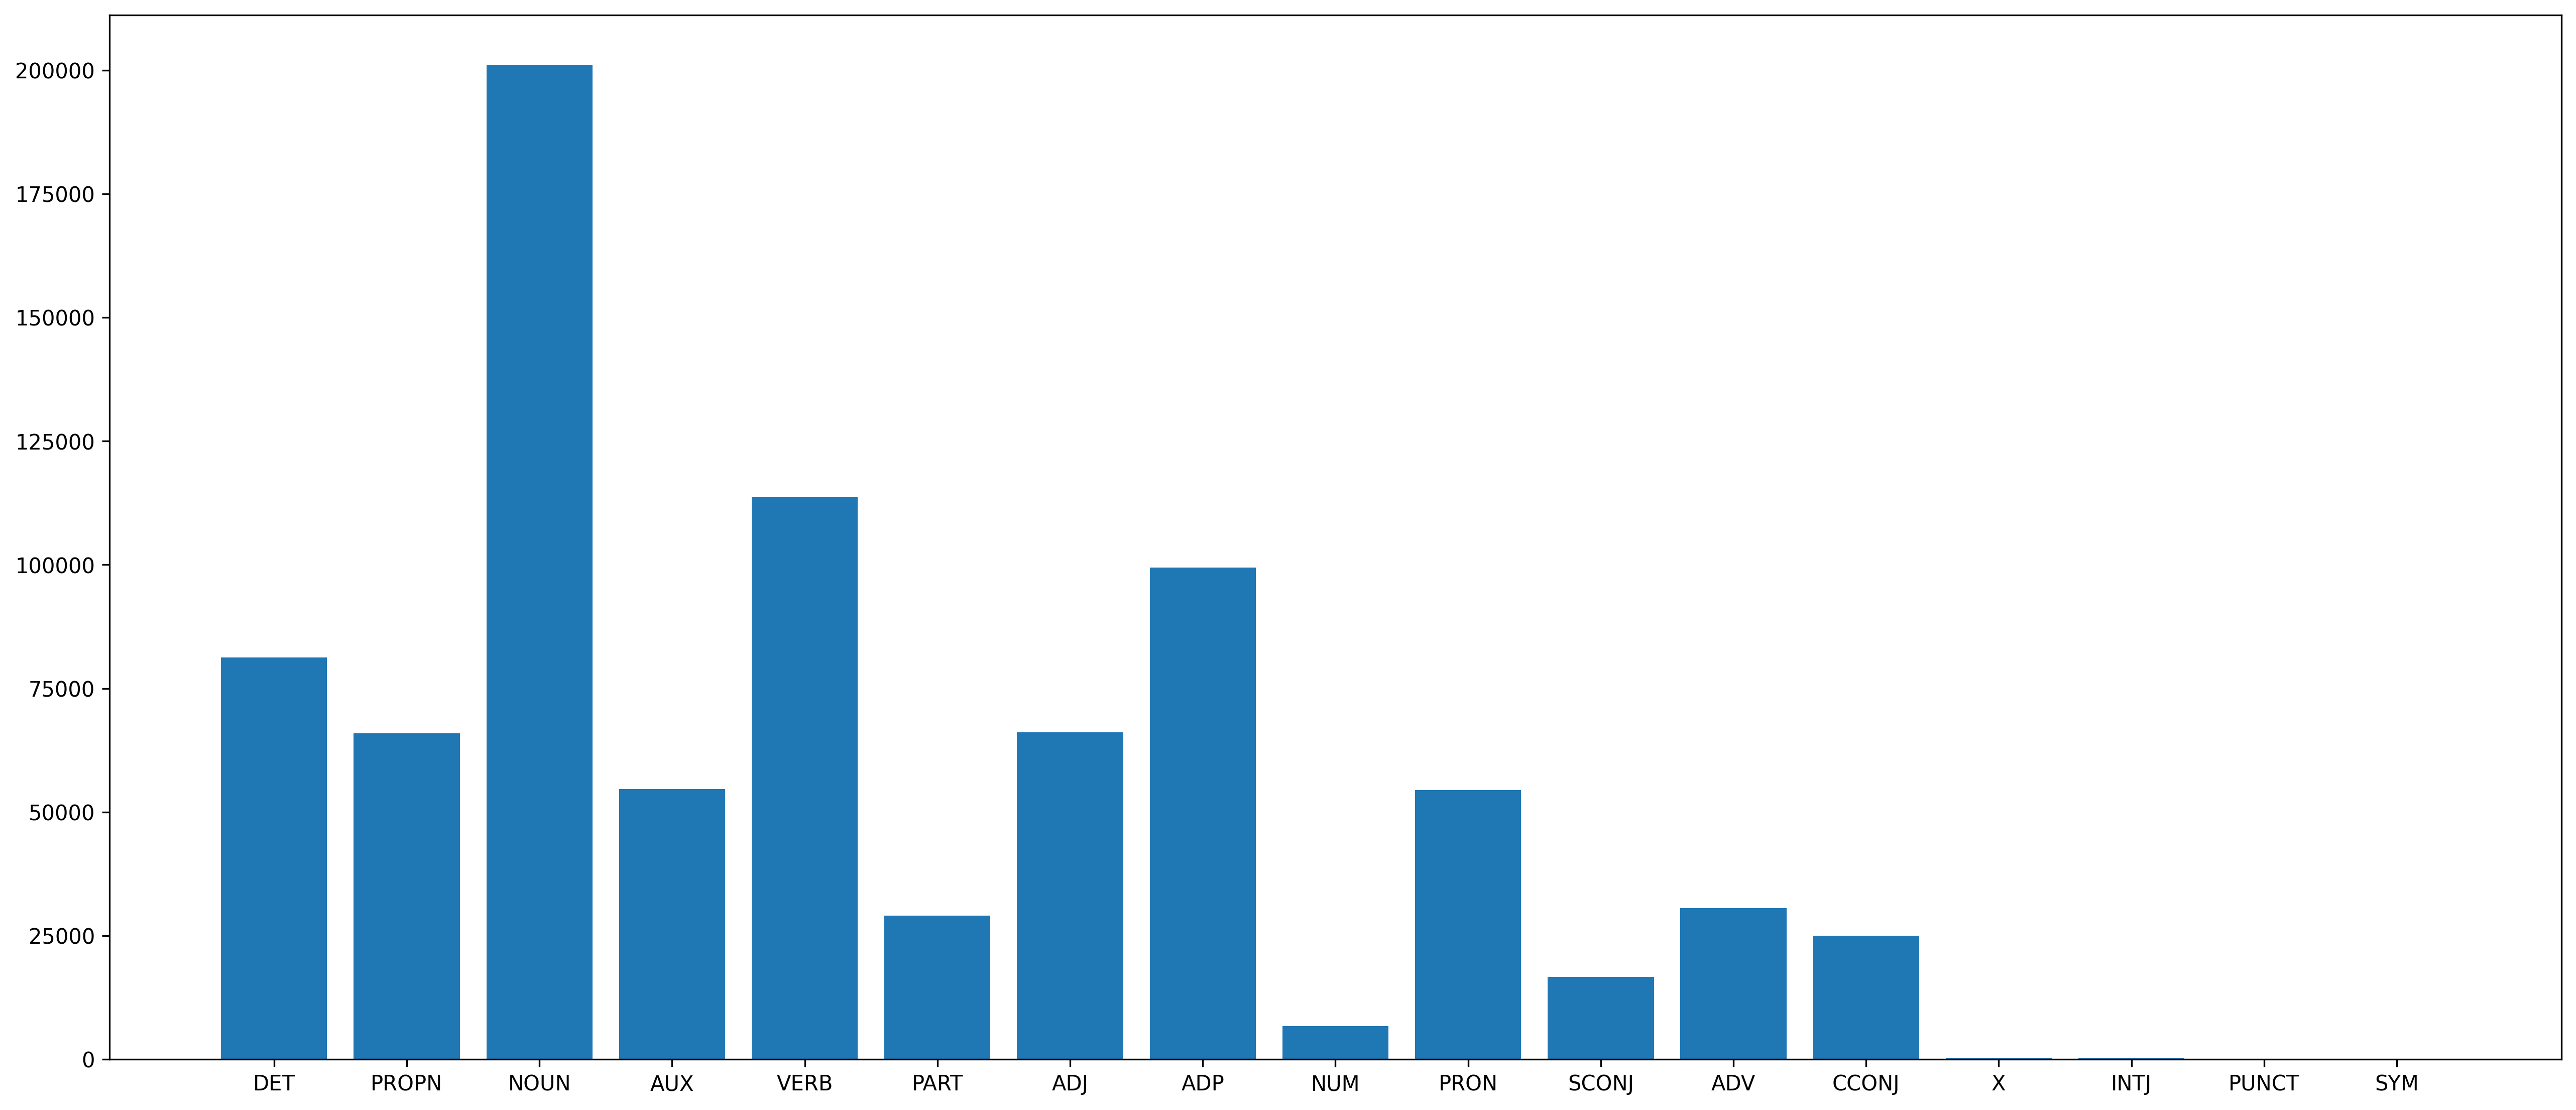

In [ ]:
plt.bar(list(counters.keys()), list(counters.values()))

### c) Extraia entidades do tipo pessoa e lugar dos seus textos.

In [ ]:
df = pd.read_csv("clean_dataset_lstm.csv")


def get_entities(element):
    # pega as entidades
    doc = nlp(element)
    # inicializa lista de entidades
    persons_and_locs = []
    # para cada entidade na noticia original
    for ent in doc.ents:
        # se for pessoal ou lugar, adiciona na lista
        if ent.label_ == 'PERSON' or ent.label_ == 'LOC' or ent.label_ == 'GPE':
            persons_and_locs.append(ent.text)
    return persons_and_locs
    
# cria coluna com os dados
df['people_places'] = df['article'].apply(lambda x: get_entities(x))

C:\Users\rafae\AppData\Roaming\Python\Python39\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


In [ ]:
display(df.head(5))

,filename,title,article,target,clean_text,people_places
0,289.txt,UK economy facing 'major risks'\n,"The UK manufacturing sector will continue to face ""serious challenges"" over the next two years, the British Chamber of Commerce (BCC) has said.\n\nThe group's quarterly survey of companies found exports had picked up in the last three months of 2004 to their best levels in eight years. The rise came despite exchange rates being cited as a major concern. However, the BCC found the whole UK economy still faced ""major risks"" and warned that growth is set to slow. It recently forecast economic growth will slow from more than 3% in 2004 to a little below 2.5% in both 2005 and 2006.\n\nManufacturers' domestic sales growth fell back slightly in the quarter, the survey of 5,196 firms found. Employment in manufacturing also fell and job expectations were at their lowest level for a year.\n\n""Despite some positive news for the export sector, there are worrying signs for manufacturing,"" the BCC said. ""These results reinforce our concern over the sector's persistent inability to sustain recovery."" The outlook for the service sector was ""uncertain"" despite an increase in exports and orders over the quarter, the BCC noted.\n\nThe BCC found confidence increased in the quarter across both the manufacturing and service sectors although overall it failed to reach the levels at the start of 2004. The reduced threat of interest rate increases had contributed to improved confidence, it said. The Bank of England raised interest rates five times between November 2003 and August last year. But rates have been kept on hold since then amid signs of falling consumer confidence and a slowdown in output. ""The pressure on costs and margins, the relentless increase in regulations, and the threat of higher taxes remain serious problems,"" BCC director general David Frost said. ""While consumer spending is set to decelerate significantly over the next 12-18 months, it is unlikely that investment and exports will rise sufficiently strongly to pick up the slack.""\n",business,the uk manufacturing sector will continue to face serious challenges over the next two years the british chamber of commerce bcc has said the group s quarterly survey of companies found exports had picked up in the last three months of to their best levels in eight years the rise came despite exchange rates being cited as a major concern however the bcc found the whole uk economy still faced major risks and warned that growth is set to slow it recently forecast economic growth will slow from more than in to a little below in both and manufacturers domestic sales growth fell back slightly in the quarter the survey of firms found employment in manufacturing also fell and job expectations were at their lowest level for a year despite some positive news for the export sector there are worrying signs for manufacturing the bcc said these results reinforce our concern over the sector s persistent inability to sustain recovery the outlook for the service sector was uncertain despite an increase in exports and orders over the quarter the bcc noted the bcc found confidence increased in the quarter across both the manufacturing and service sectors although overall it failed to reach the levels at the start of the reduced threat of interest rate increases had contributed to improved confidence it said the bank of england raised interest rates five times between november and august last year but rates have been kept on hold since then amid signs of falling consumer confidence and a slowdown in output the pressure on costs and margins the relentless increase in regulations and the threat of higher taxes remain serious problems bcc director general david frost said while consumer spending is set to decelerate significantly over the next months it is unlikely that investment and exports will rise sufficiently strongly to pick up the slack,"[UK, UK, David Frost]"
1,504.txt,Aids and climate top Da

In [ ]:
df.to_csv('clean_dataset_people_places.csv')

### d) Identifique e liste as pessoas mais frequentes nos seus textos. Você só deve contar cada entidade 1 vez por documento.


In [ ]:
df = pd.read_csv("clean_dataset_lstm.csv")


def get_people(element):
    # pega as entidades
    doc = nlp(element)
    # inicializa lista de entidades
    people = []
    # para cada entidade na noticia original
    for ent in doc.ents:
        # se for pessoa na lista
        if ent.label_ == 'PERSON':
            people.append(ent.text)
    # pega as ocorrências únicas
    people = list(set(people))
    return people
    
# cria coluna com os dados
df['unique_people'] = df['article'].apply(lambda x: get_people(x))

C:\Users\rafae\AppData\Roaming\Python\Python39\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


In [ ]:
df.to_csv("clean_dataset_people_unique.csv")

In [ ]:
from ast import literal_eval
df = pd.read_csv("clean_dataset_people_unique.csv")
df['unique_people'] = df['unique_people'].apply(literal_eval) #convert to list type
display(df.head(5))

,Unnamed: 0,filename,title,article,target,clean_text,unique_people
0,0,289.txt,UK economy facing 'major risks'\n,"The UK manufacturing sector will continue to face ""serious challenges"" over the next two years, the British Chamber of Commerce (BCC) has said.\n\nThe group's quarterly survey of companies found exports had picked up in the last three months of 2004 to their best levels in eight years. The rise came despite exchange rates being cited as a major concern. However, the BCC found the whole UK economy still faced ""major risks"" and warned that growth is set to slow. It recently forecast economic growth will slow from more than 3% in 2004 to a little below 2.5% in both 2005 and 2006.\n\nManufacturers' domestic sales growth fell back slightly in the quarter, the survey of 5,196 firms found. Employment in manufacturing also fell and job expectations were at their lowest level for a year.\n\n""Despite some positive news for the export sector, there are worrying signs for manufacturing,"" the BCC said. ""These results reinforce our concern over the sector's persistent inability to sustain recovery."" The outlook for the service sector was ""uncertain"" despite an increase in exports and orders over the quarter, the BCC noted.\n\nThe BCC found confidence increased in the quarter across both the manufacturing and service sectors although overall it failed to reach the levels at the start of 2004. The reduced threat of interest rate increases had contributed to improved confidence, it said. The Bank of England raised interest rates five times between November 2003 and August last year. But rates have been kept on hold since then amid signs of falling consumer confidence and a slowdown in output. ""The pressure on costs and margins, the relentless increase in regulations, and the threat of higher taxes remain serious problems,"" BCC director general David Frost said. ""While consumer spending is set to decelerate significantly over the next 12-18 months, it is unlikely that investment and exports will rise sufficiently strongly to pick up the slack.""\n",business,the uk manufacturing sector will continue to face serious challenges over the next two years the british chamber of commerce bcc has said the group s quarterly survey of companies found exports had picked up in the last three months of to their best levels in eight years the rise came despite exchange rates being cited as a major concern however the bcc found the whole uk economy still faced major risks and warned that growth is set to slow it recently forecast economic growth will slow from more than in to a little below in both and manufacturers domestic sales growth fell back slightly in the quarter the survey of firms found employment in manufacturing also fell and job expectations were at their lowest level for a year despite some positive news for the export sector there are worrying signs for manufacturing the bcc said these results reinforce our concern over the sector s persistent inability to sustain recovery the outlook for the service sector was uncertain despite an increase in exports and orders over the quarter the bcc noted the bcc found confidence increased in the quarter across both the manufacturing and service sectors although overall it failed to reach the levels at the start of the reduced threat of interest rate increases had contributed to improved confidence it said the bank of england raised interest rates five times between november and august last year but rates have been kept on hold since then amid signs of falling consumer confidence and a slowdown in output the pressure on costs and margins the relentless increase in regulations and the threat of higher taxes remain serious problems bcc director general david frost said while consumer spending is set to decelerate significantly over the next months it is unlikely that investment and exports will rise sufficiently strongly to pick up the slack,[David Frost]
1,1,504.txt,Aids and climate t

<AxesSubplot:>

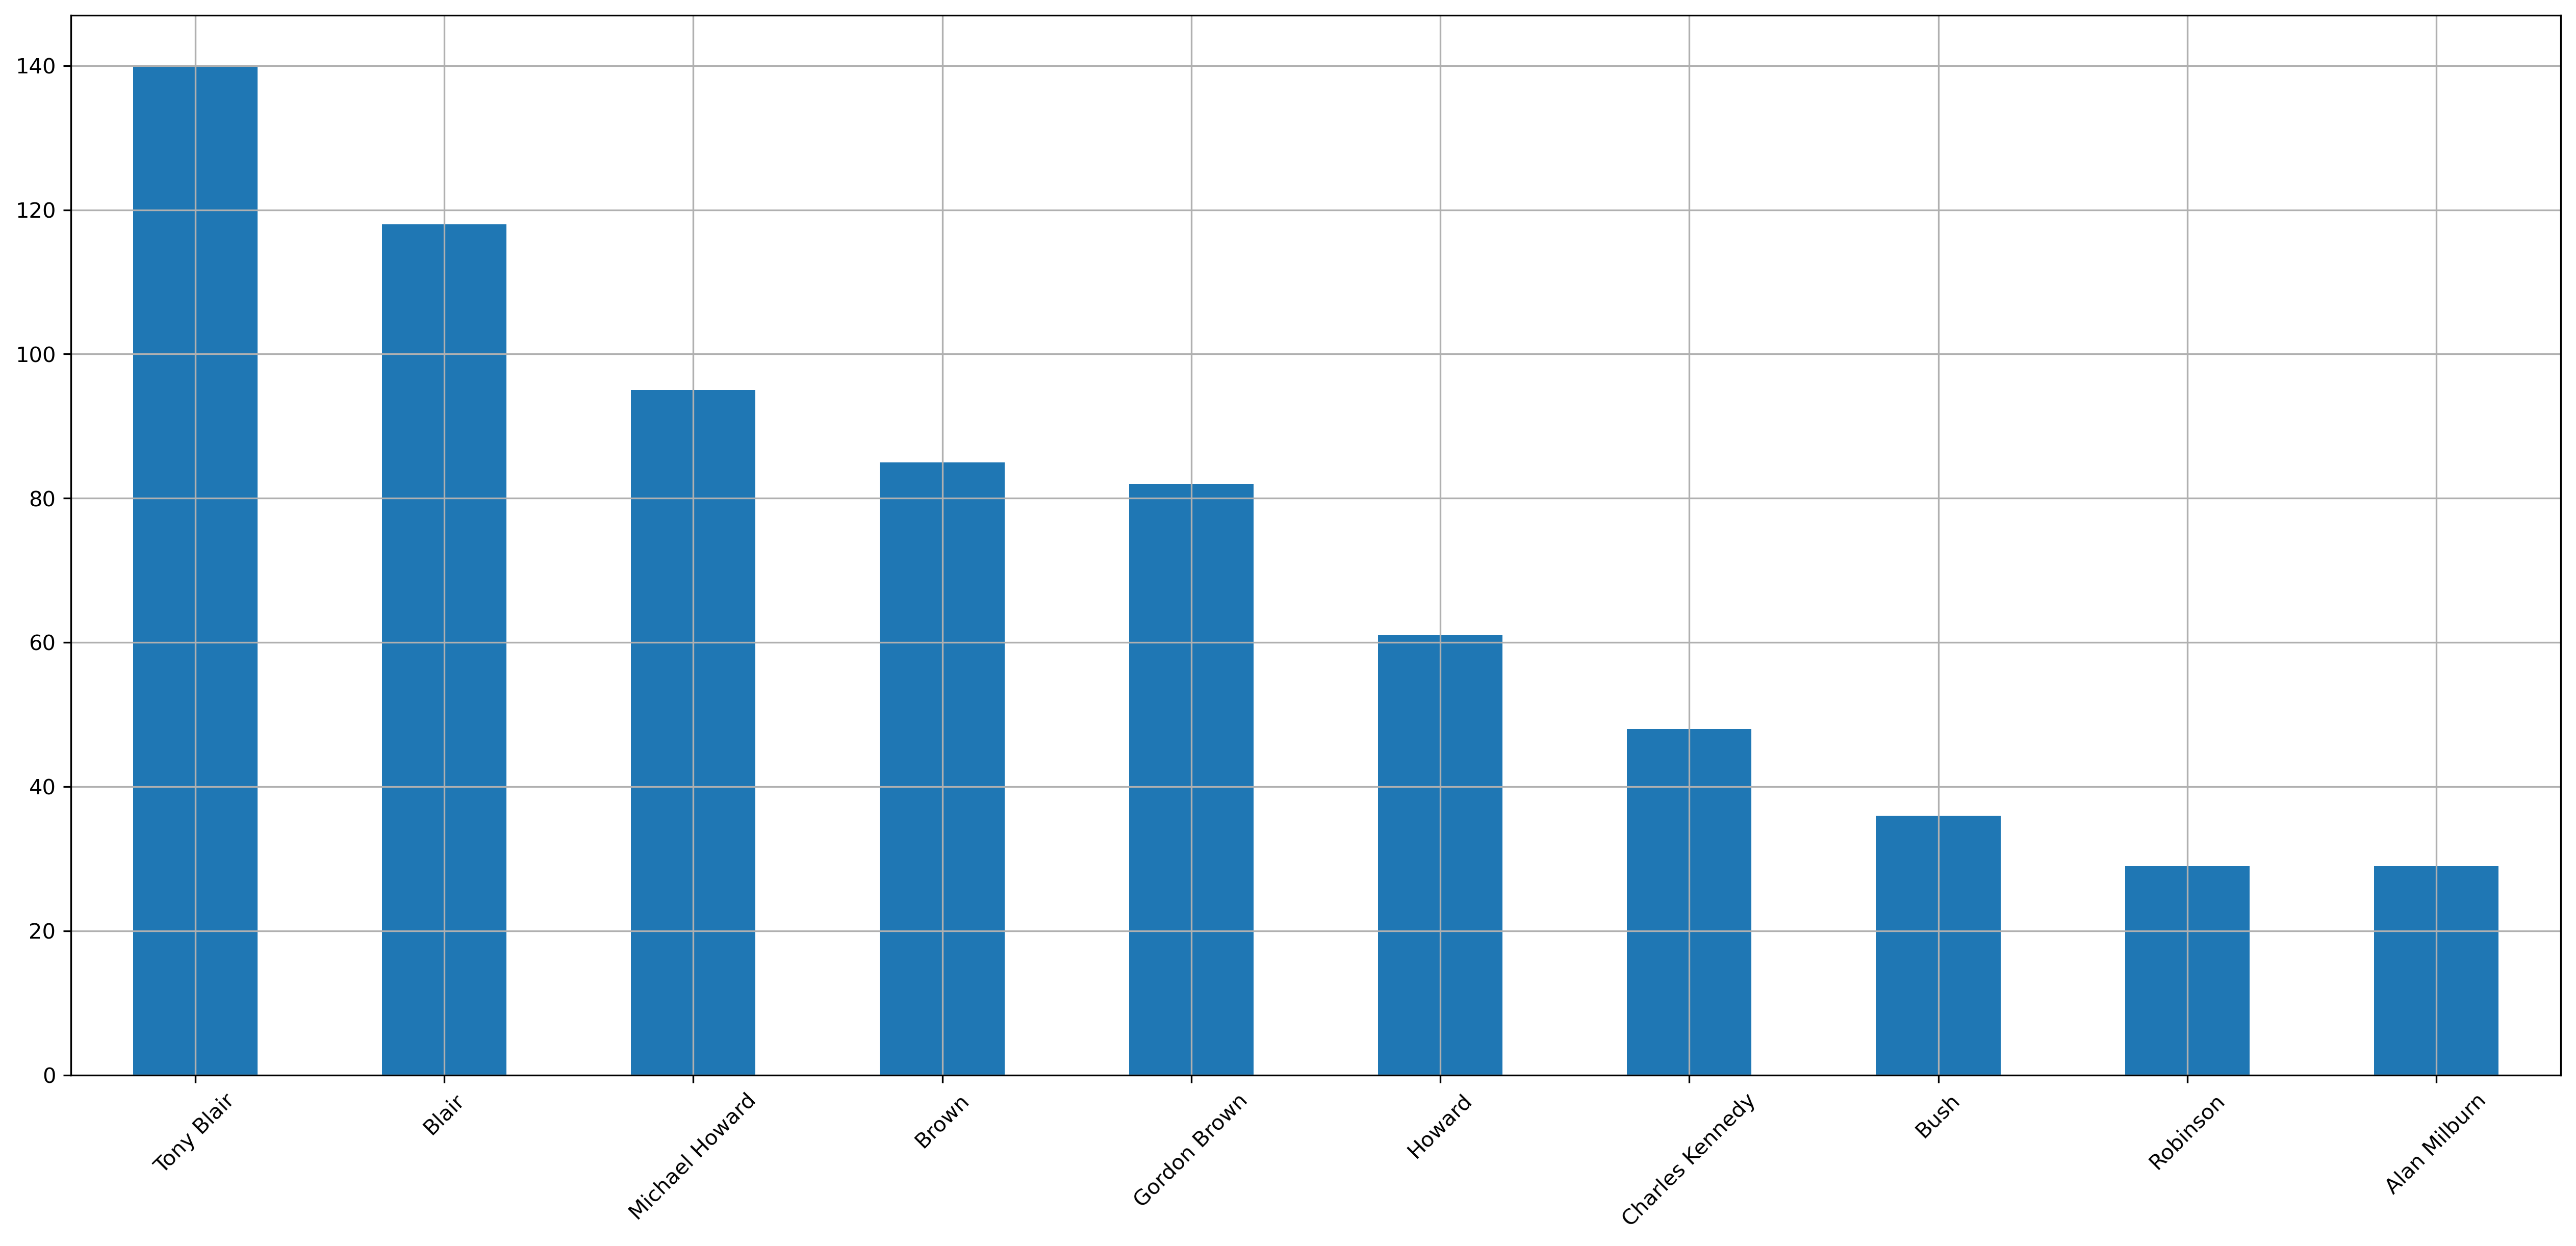

In [ ]:
# Conta a quantidade de pessoas ao longo do dataset que são únicas em cada notícia
counters_people = df['unique_people'].explode().value_counts()
# pega as 10 mais frequentes
counters_people = counters_people.head(10)
counters_people.plot.bar(rot=45,grid=True)